In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import openpyxl
import fnmatch
import tensorflow as tf
import random
import datetime

from tensorflow.keras.models import load_model
from tensorflow.python.keras.optimizer_v2.rmsprop import RMSProp
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv, DataFrame, concat
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, RepeatVector, LSTM, Input, TimeDistributed, Activation, Dropout
from keras.optimizers import SGD
from pandas import read_csv
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer 
#from feature_engine import variable_transformers as vt
from scipy.stats import yeojohnson

np.set_printoptions(suppress=True)

EPOCHS       = 500
BATCH_SIZE   = 256

SHIFT_DAYS   = 3
PRED_STEPS   = 48 #48hr * 10분단위 예측
TIME_STEPS   = SHIFT_DAYS*PRED_STEPS #hours step
DIMENSION    = 15
MODEL_NUM    = 10
CAPACITY     = 89.7


TRAIN_RATIO  = 0.6
VAL_RATIO    = 0.2

START_DATE = '20210129'
END_DATE   = '20210531'
FILE_NAME  =  START_DATE+'_'+END_DATE


BASE_PATH = 'C:/elsys/solar/'
RSRSID_list=['RSRS0000000239', 'RSRS0000000241', 'RSRS0000000247', 'RSRS0000000249']

NOWDATE = str(datetime.datetime.now()).replace("-", "").replace(":", "").replace(" ", "_").replace(".", "_")
SAVE_PATH = BASE_PATH+'data/'+str(NOWDATE)+'/'
os.mkdir(SAVE_PATH)

FILE_SEED = NOWDATE[-6:]
SAVE_NAME = str(FILE_SEED)+'_1h_'+str(EPOCHS)+'e_'+str(BATCH_SIZE)+'b'
print("SAVE_NAME : ", SAVE_NAME)


SAVE_PATH = BASE_PATH+'data/20210604_034240_554278/'
SAVE_NAME = '554278_1h_200e_128b'


SAVE_NAME :  734054_1h_500e_256b


In [3]:
# power
power_df = read_csv(BASE_PATH+'_onm_df_20210129_20210531_1hour.csv', encoding='CP949', converters={'DATE':int})
display(power_df)

# sensor    
sensor_df = read_csv(BASE_PATH+'_sensor_df_1hour.csv', encoding='CP949', converters={'DATE':int})
sensor_df = sensor_df.interpolate(method='linear')
sensor_df.to_csv(BASE_PATH+'_sensor_df_1hour_interpolate.csv', encoding='CP949',mode='w',index=False)

#sensor_df['date'] = sensor_df['date'].astype('int')
display(sensor_df)

DATE  POWER
0     2021012901    0.0
1     2021012902    0.0
2     2021012903    0.0
3     2021012904    0.0
4     2021012905    0.0
...          ...    ...
2947  2021053120    0.6
2948  2021053121    0.0
2949  2021053122    0.0
2950  2021053123    0.0
2951  2021053124    0.0

[2952 rows x 2 columns]

DATE  solarradiation   uv    temp  humidity  winddir  windspeed  \
0     2021012901            0.00  0.0  -4.722      77.0    331.0      3.979   
1     2021012902            0.00  0.0  -4.889      85.0    353.0      4.604   
2     2021012903            0.00  0.0  -5.278      78.0    358.0      4.381   
3     2021012904            0.00  0.0  -5.500      78.0    357.0      4.113   
4     2021012905            0.00  0.0  -5.778      76.0    351.0      2.995   
...          ...             ...  ...     ...       ...      ...        ...   
2947  2021053120           39.82  0.0  22.778      62.0    222.0      0.000   
2948  2021053121            0.00  0.0  18.111      71.0    152.0      0.000   
2949  2021053122            0.00  0.0  15.611      76.0    145.0      0.000   
2950  2021053123            0.00  0.0  14.222      84.0    154.0      0.000   
2951  2021053124            0.00  0.0  13.389      89.0    155.0      0.000   

      windgust  dewpoint  maxdailygust  feelslike  hourlyrainin  dailyrainin  \
0        7.778    -8.128        11.086     -7.339           0.0          0.0   
1        6.705    -7.394        11.086     -5.389           0.0          0.0   
2        8.896    -8.500        11.086     -5.278           0.0          0.0   
3        5.498    -8.717        11.086     -5.500           0.0          0.0   
4        5.498    -9.317        11.086     -9.194           0.0          0.0   
...        ...       ...           ...        ...           ...          ...   
2947     0.000    12.344         5.498     22.417           0.0          0.0   
2948     0.000    11.422         5.498     18.111           0.0          0.0   
2949     0.000    10.428         5.498     15.611           0.0          0.0   
2950     0.000    10.956         5.498     14.222           0.0          0.0   
2951     0.000    11.228         5.498     13.389           0.0          0.0   

      weeklyrainin  monthlyrainin  yearlyrainin  
0           12.192         12.192        12.192  
1           12.192         12.192        12.192  
2           12.192         12.192        12.192  
3           12.192         12.192        12.192  
4           12.192         12.192        12.192  
...            ...            ...           ...  
2947         0.000         96.520       502.412  
2948         0.000         96.520       502.412  
2949         0.000         96.520       502.412  
2950         0.000         96.520       502.412  
2951         0.000         96.520       502.412  

[2952 rows x 16 columns]

In [5]:
df = sensor_df.copy()
df.drop(['DATE'], axis=1)

df.insert(0, 'POWER', power_df['POWER'].values, True)

df.to_csv(BASE_PATH+"/_total_df_"+FILE_NAME+"_1hour.csv",mode='w',index=False, encoding='CP949')
display(df)

POWER        DATE  solarradiation   uv    temp  humidity  winddir  \
0       0.0  2021012901            0.00  0.0  -4.722      77.0    331.0   
1       0.0  2021012902            0.00  0.0  -4.889      85.0    353.0   
2       0.0  2021012903            0.00  0.0  -5.278      78.0    358.0   
3       0.0  2021012904            0.00  0.0  -5.500      78.0    357.0   
4       0.0  2021012905            0.00  0.0  -5.778      76.0    351.0   
...     ...         ...             ...  ...     ...       ...      ...   
2947    0.6  2021053120           39.82  0.0  22.778      62.0    222.0   
2948    0.0  2021053121            0.00  0.0  18.111      71.0    152.0   
2949    0.0  2021053122            0.00  0.0  15.611      76.0    145.0   
2950    0.0  2021053123            0.00  0.0  14.222      84.0    154.0   
2951    0.0  2021053124            0.00  0.0  13.389      89.0    155.0   

      windspeed  windgust  dewpoint  maxdailygust  feelslike  hourlyrainin  \
0         3.979     7.778    -8.128        11.086     -7.339           0.0   
1         4.604     6.705    -7.394        11.086     -5.389           0.0   
2         4.381     8.896    -8.500        11.086     -5.278           0.0   
3         4.113     5.498    -8.717        11.086     -5.500           0.0   
4         2.995     5.498    -9.317        11.086     -9.194           0.0   
...         ...       ...       ...           ...        ...           ...   
2947      0.000     0.000    12.344         5.498     22.417           0.0   
2948      0.000     0.000    11.422         5.498     18.111           0.0   
2949      0.000     0.000    10.428         5.498     15.611           0.0   
2950      0.000     0.000    10.956         5.498     14.222           0.0   
2951      0.000     0.000    11.228         5.498     13.389           0.0   

      dailyrainin  weeklyrainin  monthlyrainin  yearlyrainin  
0             0.0        12.192         12.192        12.192  
1             0.0        12.192         12.192        12.192  
2             0.0        12.192         12.192        12.192  
3             0.0        12.192         12.192        12.192  
4             0.0        12.192         12.192        12.192  
...           ...           ...            ...           ...  
2947          0.0         0.000         96.520       502.412  
2948          0.0         0.000         96.520       502.412  
2949          0.0         0.000         96.520       502.412  
2950          0.0         0.000         96.520       502.412  
2951          0.0         0.000         96.520       502.412  

[2952 rows x 17 columns]

In [6]:
# scale
power_df.drop(['DATE'], axis=1, inplace=True)
pow_scaler = MinMaxScaler(feature_range = (0, 1))
scaled_pow = pow_scaler.fit_transform(power_df.values)
power_scaleddf = pd.DataFrame(scaled_pow, columns=power_df.columns, index=list(power_df.index.values))

weather_df = sensor_df.copy()
weather_df.drop(['DATE'], axis=1, inplace=True)
weather_scaler = MinMaxScaler(feature_range = (0, 1))#scale
scaled_weather = weather_scaler.fit_transform(weather_df.values)
weather_scaleddf = pd.DataFrame(scaled_weather, columns=weather_df.columns, index=list(weather_df.index.values))

# JOIN 
df = weather_scaleddf.copy()

# pow + weather + powY
df.insert(0, 'POWER', power_scaleddf.values, True)
df = df.iloc[0:-TIME_STEPS, :]
df.insert(df.shape[1], 'POWER_Y', power_scaleddf.iloc[TIME_STEPS:, :].values, True)

df.to_csv(BASE_PATH+"/_total_scaled_df_"+FILE_NAME+"_1hour.csv",mode='w',index=False, encoding='CP949')
display(df)

POWER  solarradiation   uv      temp  humidity   winddir  windspeed  \
0     0.000000        0.000000  0.0  0.126622  0.728395  0.920228   0.432077   
1     0.000000        0.000000  0.0  0.122297  0.827160  0.982906   0.499946   
2     0.000000        0.000000  0.0  0.112222  0.740741  0.997151   0.475730   
3     0.000000        0.000000  0.0  0.106472  0.740741  0.994302   0.446628   
4     0.000000        0.000000  0.0  0.099272  0.716049  0.977208   0.325225   
...        ...             ...  ...       ...       ...       ...        ...   
2803  0.005251        0.040478  0.0  0.733806  0.493827  0.985755   0.009664   
2804  0.000000        0.000000  0.0  0.670508  0.629630  0.951567   0.063090   
2805  0.000000        0.000000  0.0  0.643159  0.777778  0.834758   0.000000   
2806  0.000000        0.000000  0.0  0.588485  0.851852  0.421652   0.000000   
2807  0.000000        0.000000  0.0  0.556836  0.888889  0.458689   0.000000   

      windgust  dewpoint  maxdailygust  feelslike  hourlyrainin  dailyrainin  \
0     0.498558  0.158178      0.663078   0.057301           0.0          0.0   
1     0.429780  0.179311      0.663078   0.106482           0.0          0.0   
2     0.570220  0.147468      0.663078   0.109281           0.0          0.0   
3     0.352413  0.141220      0.663078   0.103682           0.0          0.0   
4     0.352413  0.123946      0.663078   0.010517           0.0          0.0   
...        ...       ...           ...        ...           ...          ...   
2803  0.071662  0.634353      0.866320   0.714578           0.0          0.0   
2804  0.071662  0.669219      0.866320   0.652938           0.0          0.0   
2805  0.000000  0.698183      0.866320   0.626305           0.0          0.0   
2806  0.000000  0.683154      0.866320   0.573064           0.0          0.0   
2807  0.000000  0.679152      0.866320   0.542245           0.0          0.0   

      weeklyrainin  monthlyrainin  yearlyrainin   POWER_Y  
0         0.133333       0.051227      0.000000  0.000000  
1         0.133333       0.051227      0.000000  0.000000  
2         0.133333       0.051227      0.000000  0.000000  
3         0.133333       0.051227      0.000000  0.000000  
4         0.133333       0.051227      0.000000  0.000000  
...            ...            ...           ...       ...  
2803      0.002778       0.391676      0.993264  0.004501  
2804      0.002778       0.391676      0.993264  0.000000  
2805      0.002778       0.391676      0.993264  0.000000  
2806      0.002778       0.391676      0.993264  0.000000  
2807      0.002778       0.391676      0.993264  0.000000  

[2808 rows x 17 columns]

# Get weather, pow data (1시간 간격 센서용)

In [12]:
def getData():
    # power
    power_file  = './data/power_20210129_20210429_preprocess_1hour'
    power_df = read_csv(power_file+'.csv', encoding='CP949', converters={'date':int})
    print(power_df.shape)
        
    # sensor    
    sensor_file = 'data/sensor_20210129_20210429_preprocess_1hour'
    sensor_df = read_csv(sensor_file+'.csv', encoding='CP949', converters={'date':int})
    #sensor_df['date'] = sensor_df['date'].astype('int')
    sensor_df = sensor_df.sort_values('date')
    print(sensor_df.shape)

    ''' JOIN TEST '''
    join_test = sensor_df.copy()

    # pow + weather + powY
    join_test.insert(0, 'pow', power_df['power'].values, True)
    #print(join_test)
    join_test.to_csv(SAVE_PATH+"join_test"+SAVE_NAME+".csv",mode='w',index=False, encoding='CP949')

    # scale
    power_df.drop(['date'], axis=1, inplace=True)
    pow_scaler = MinMaxScaler(feature_range = (0, 1))
    scaled_pow = pow_scaler.fit_transform(power_df.values)
    power_scaleddf = pd.DataFrame(scaled_pow, columns=power_df.columns, index=list(power_df.index.values))

    weather_df = sensor_df.copy()
    weather_df.drop(['date'], axis=1, inplace=True)
    weather_scaler = MinMaxScaler(feature_range = (0, 1))#scale
    scaled_weather = weather_scaler.fit_transform(weather_df.values)
    weather_scaleddf = pd.DataFrame(scaled_weather, columns=weather_df.columns, index=list(weather_df.index.values))

    # JOIN 
    df = weather_scaleddf.copy()

    # pow + weather + powY
    df.insert(0, 'pow', power_scaleddf.values, True)
    df = df.iloc[0:-TIME_STEPS, :]
    df.insert(df.shape[1], 'pow_Y', power_scaleddf.iloc[TIME_STEPS:, :].values, True)

    df.to_csv(SAVE_PATH+"total_scaled"+SAVE_NAME+".csv",mode='w',index=False, encoding='CP949')
    #display(df) 

    return pow_scaler, df

pow_scaler, df = getData()

(2184, 2)
(2184, 17)


# Numpy data
weather, pow

In [40]:
#correlation
corr_df = df.corr()
corr_df = corr_df.apply(lambda x: round(x ,2))
display(corr_df[0:1])
corr_df1 = corr_df.nlargest(df.shape[0], 'POWER')
corr_df1 = corr_df1[list(corr_df1.index)]
display(corr_df1[0:1])

POWER  solarradiation    uv  temp  humidity  winddir  windspeed  \
POWER    1.0            0.76  0.84  0.32     -0.48     0.31       0.37   

       windgust  dewpoint  maxdailygust  feelslike  hourlyrainin  dailyrainin  \
POWER      0.35     -0.04          0.08       0.31         -0.11        -0.12   

       weeklyrainin  monthlyrainin  yearlyrainin  POWER_Y  
POWER         -0.01           0.04          0.04     0.74

POWER    uv  solarradiation  POWER_Y  windspeed  windgust  temp  \
POWER    1.0  0.84            0.76     0.74       0.37      0.35  0.32   

       winddir  feelslike  maxdailygust  monthlyrainin  yearlyrainin  \
POWER     0.31       0.31          0.08           0.04          0.04   

       weeklyrainin  dewpoint  hourlyrainin  dailyrainin  humidity  
POWER         -0.01     -0.04         -0.11        -0.12     -0.48

In [42]:
#df.drop(['hourlyrainin','monthlyrainin','yearlyrainin','weeklyrainin','uv','feelslike','temp','windgust','maxdailygust'], axis=1, inplace=True)
df.corr(method='pearson')

POWER  solarradiation  humidity   winddir  windspeed  \
POWER           1.000000        0.762387 -0.484452  0.311157   0.366168   
solarradiation  0.762387        1.000000 -0.668907  0.368523   0.495960   
humidity       -0.484452       -0.668907  1.000000 -0.360783  -0.506916   
winddir         0.311157        0.368523 -0.360783  1.000000   0.448952   
windspeed       0.366168        0.495960 -0.506916  0.448952   1.000000   
dewpoint       -0.037482        0.138215  0.246184  0.087051  -0.138727   
dailyrainin    -0.117996       -0.110073  0.201050  0.067414   0.012653   
POWER_Y         0.742497        0.635544 -0.349025  0.282096   0.268550   

                dewpoint  dailyrainin   POWER_Y  
POWER          -0.037482    -0.117996  0.742497  
solarradiation  0.138215    -0.110073  0.635544  
humidity        0.246184     0.201050 -0.349025  
winddir         0.087051     0.067414  0.282096  
windspeed      -0.138727     0.012653  0.268550  
dewpoint        1.000000     0.194870  0.065422  
dailyrainin     0.194870     1.000000 -0.027008  
POWER_Y         0.065422    -0.027008  1.000000

In [45]:
def show_shapes(): # can make yours to take inputs; this'll use local variable values
    print("Expected: (num_samples, TIME_STEPS, channels)")
    print("trainX:{}\t {} \t/ {}\t {}".format(trainX.dtype, trainX.shape, trainY.dtype, trainY.shape))
    print("valX:  {}\t {} \t/ {}\t {}".format(valX.dtype, valX.shape, valY.dtype, valY.shape))
    print("testX: {}\t {} \t/ {}\t {}".format(testX.dtype, testX.shape, testY.dtype, testY.shape))
    
#############################################
# create nparray
#############################################
# time step만큼 window 움직여 dataset 생성
totalsize = df.shape[0]
dataX, dataY = [], []
print("DF_SIZE: {}, TIME_STEPS: {}, PRED_STEPS: {}\n".format(df.shape,TIME_STEPS, PRED_STEPS))
for i in range(0, totalsize-TIME_STEPS-24+1, PRED_STEPS):
    dataX.append(df.iloc[i:(i + TIME_STEPS),0:-1])
    dataY.append(df.iloc[i:(i + PRED_STEPS),[-1]])

print("len(dataX) : ", len(dataX), dataX[0].shape)
print("len(dataY) : ", len(dataY), dataY[0].shape)

#  Split train/test 
train_size = int(len(dataX) * TRAIN_RATIO)
val_size   = int(len(dataX) * VAL_RATIO)
test_size  = len(dataX) - train_size - val_size
val_idx = train_size+val_size

trainX, valX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:val_idx]), np.array(dataX[val_idx:val_idx+test_size])
trainY, valY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:val_idx]), np.array(dataY[val_idx:val_idx+test_size])

print('train X : ', trainX.shape, '\tY : ', trainY.shape)
print('val   X : ', valX.shape,   '\tY : ', valY.shape)
print('test  X : ', testX.shape,  '\tY : ', testY.shape)

np.save(SAVE_PATH+"npset_"+SAVE_NAME+"_trainX",trainX)
np.save(SAVE_PATH+"npset_"+SAVE_NAME+"_trainY",trainY)
np.save(SAVE_PATH+"npset_"+SAVE_NAME+"_valX",valX)
np.save(SAVE_PATH+"npset_"+SAVE_NAME+"_valY",valY)
np.save(SAVE_PATH+"npset_"+SAVE_NAME+"_testX",testX)
np.save(SAVE_PATH+"npset_"+SAVE_NAME+"_testY",testY)

show_shapes()

trainX=np.asarray(trainX).astype(np.float64)
trainY=np.asarray(trainY).astype(np.float64)
valX=np.asarray(valX).astype(np.float64)
valY=np.asarray(valY).astype(np.float64)
testX=np.asarray(testX).astype(np.float64)
testY=np.asarray(testY).astype(np.float64)


DF_SIZE: (2808, 8), TIME_STEPS: 144, PRED_STEPS: 48

len(dataX) :  56 (144, 7)
len(dataY) :  56 (48, 1)
train X :  (33, 144, 7) 	Y :  (33, 48, 1)
val   X :  (11, 144, 7) 	Y :  (11, 48, 1)
test  X :  (12, 144, 7) 	Y :  (12, 48, 1)
Expected: (num_samples, TIME_STEPS, channels)
trainX:float64	 (33, 144, 7) 	/ float64	 (33, 48, 1)
valX:  float64	 (11, 144, 7) 	/ float64	 (11, 48, 1)
testX: float64	 (12, 144, 7) 	/ float64	 (12, 48, 1)


In [46]:

#############################################
# modeling
#############################################
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(256, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(tf.keras.layers.RepeatVector(PRED_STEPS))
model.add(tf.keras.layers.LSTM(256, return_sequences=True))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(256, activation='relu')))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)))
model.summary()

modelList  = []
histList   = []
resultList = []
for i in range(MODEL_NUM):#0,5):#
    #keras.optimizers.RMSprop(lr=0.005, rho=0.9, epsilon=None, decay=0.0)
    model.compile(loss='mean_squared_error', 
                    optimizer=RMSProp()
                    #optimizer=RMSProp(learning_rate=0.001)
                    #optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True), 
                    #metrics=['acc'])
                    )

    hist = model.fit(trainX, trainY, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(valX, valY))
    results = model.evaluate(testX, testY)
    model.save(SAVE_PATH+'model_'+SAVE_NAME+'_'+str(i)+'.h5')# # of feature=3,5,7,9,?,12,14,16,18
    model.save(SAVE_PATH+'model_'+SAVE_NAME+'_'+str(i)+'.h5')# # of feature=3,5,7,9,?,12,14,16,18
    
    modelList.append(model)
    histList.append(hist)
    resultList.append(results)


#############################################
# Prediction Error Rate
#############################################
# 예측 오차율 계산
#plt.rcParams['font.size'] = 10
predErrRate_list = []
modelList = []
for n in range(MODEL_NUM):
    modelList.append(load_model(SAVE_PATH+'model_'+SAVE_NAME+'_'+str(n)+'.h5'))

for n in range(MODEL_NUM):
    errRate = []
    y = pow_scaler.inverse_transform(trainY[:,:,0])
    plotY = y.reshape(-1,1)

    pred = modelList[n].predict(trainX)[:,:,0]
    pred[pred<0] = 0
    x = pow_scaler.inverse_transform(pred)
    plot_pred = x.reshape(-1,1)

    target_list=[]
    for i in range(0, plotY.shape[0], PRED_STEPS):
        for hr in range(0, PRED_STEPS):
            pred   = plot_pred[i+hr]
            target = plotY[i+hr]
            difference = np.abs(target-pred)
            errRate.append(np.round(difference/CAPACITY*100, 2))

            #print("|t:",target,"-p:",pred,"|=",err,",예측오차율:",predErrRate)
            #err_list.append(err)
            
            target_list.append(target)
            
    predErrRate_list.append(errRate)
    #print(n,";",np.shape(predErrRate_list[n]))
    print(n," avg;",np.round(sum(predErrRate_list[n])/len(predErrRate_list[n]),4),end='')
    print("\t max;",max(predErrRate_list[n]),end='')
    print("\t val_loss;",np.round(resultList[n],4))
    
# save csv files    
print(np.shape(predErrRate_list))
predErrRate_df = pd.DataFrame(predErrRate_list).transpose()
predErrRate_df.to_csv(SAVE_PATH+"predErrRate_"+SAVE_NAME+".csv",mode='w',index=False, encoding='CP949')

histList_df = pd.DataFrame(histList).transpose()
histList_df.to_csv(SAVE_PATH+"histList_"+SAVE_NAME+".csv",mode='w',index=False, encoding='CP949')

resultList_df = pd.DataFrame(resultList).transpose()
resultList_df.to_csv(SAVE_PATH+"resultList_"+SAVE_NAME+".csv",mode='w',index=False, encoding='CP949')



####################################################### TEST
n_dataset   = testY.shape[0]
acc_list    = []
acc_model   = []
predictModel = []
predList=[]
predErrRate_list=[]
yList=[]
print(n_dataset)

print("[ model ]")
for m in range(MODEL_NUM):
    errRate=[]
    print("-"*70,"[ model {} ]".format(m))
#for m in range(2):
    plot_target=[]
    plot_predict=[]
    for i in range(n_dataset):
        #print("(dataset {}) : ".format(i), end='')
    #for i in range(5):
    #if(i in [2,3,4,5,6,7,8]): continue;
        y = pow_scaler.inverse_transform(testY[i:i+1,:,0])
        yList = y.reshape(-1,1)

        pred = modelList[m].predict([testX[i:i+1]])
        pred[pred<0] = 0
        pred = pred[:,:,0]
        pred = pow_scaler.inverse_transform(pred)
        predSum = np.sum(pred)
        predList = pred.reshape(-1,1)

        target_list=[]
        for i in range(0, yList.shape[0], PRED_STEPS):
            for hr in range(0, PRED_STEPS):
                pred   = predList[i+hr]
                target = yList[i+hr]
                difference = np.abs(target-pred)
                errRate.append(np.round(difference/CAPACITY*100, 2))
                target_list.append(target)

        target      = round(np.sum(y), 2)
        error       = round(np.abs(target-predSum), 2)
        error_rate  = np.min([round(error/target, 2),1])
        acc_rate    = round((1.0-error_rate)*100, 2)
        acc_list.append(acc_rate)
        #print("acc rate: ",np.mean(acc_list[-n_model:]),sep='')
        #predErrRateTest_AllModel.append(predErrRateTest)
        print(np.round(np.mean(acc_list[-MODEL_NUM:]),2), " / ",sep='',end='')
        
    predErrRate_list.append(errRate)
    print(" \tErr Rate avg;",np.round(sum(predErrRate_list[m])/len(predErrRate_list[m]),2),end='')
    print(" \t max;",np.max(predErrRate_list[m]))

print("\npredErrRate_list:{}".format(np.shape(predErrRate_list)))
predErrRate_df = pd.DataFrame(predErrRate_list).transpose()
predErrRate_df.to_csv(SAVE_PATH+"predErrRate_"+SAVE_NAME+"_TEST333.csv",mode='w',index=False, encoding='CP949')
print("----------------------------------------------")
print("mean(acc rate): ",np.mean(acc_list),sep='')
print("----------------------------------------------")
print("[ model ]")
#for m in range(MODEL_NUM):
    #print(predErrRateTest_AllModel[m])
    #acc_model[i] = round(acc_model[i]/(n_dataset),2)
    #print(acc_model[i])

# print Err Rate
listsize = len(predErrRate_list[0])
count = []
column_names = ["0 < x < 6","(%)","6 < x < 8","(%)","8 < x < 10","(%)", "0 < x < 10","(%)",]
for m in range(MODEL_NUM):
    testList = predErrRate_list[m].copy()
    testList.sort()
    #count = sum(map(lambda x : x>5, listOfElems))
    count.append(int(sum(map(lambda x : x<6, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    count.append(int(sum(map(lambda x : x>6 and x < 8, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    count.append(int(sum(map(lambda x : x>8 and x < 10, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    count.append(np.round(sum(map(lambda x : x < 10, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    
countArr = np.array(count).reshape(10,-1)
countDf = pd.DataFrame(countArr, columns = column_names)
print(countDf)
print("0 < x < 10 (%) : AVG {} \t MIN {} \t MAX {}".format(np.mean(countDf.iloc[:,-1]), np.min(countDf.iloc[:,-1]), np.max(countDf.iloc[:,-1])))
#acc_list.append(acc_rate)
#print("   pred: ",pred," | target: ",target," | error: ",error," | err rate: ",error_rate," | acc: ",acc_rate,sep="")
#print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간
print("SAVE_NAME : ", SAVE_NAME)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               270336    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 48, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 48, 256)           525312    
_________________________________________________________________
time_distributed (TimeDistri (None, 48, 256)           65792     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 48, 1)             257       
Total params: 861,697
Trainable params: 861,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
1/1 [==============================] - 1s 719ms/step - loss: 0.0621 - val_loss: 0.5879
Epoch 2/500
1/1 [

1/1 [==============================] - 0s 27ms/step - loss: 0.0163 - val_loss: 0.0176
Epoch 156/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0126 - val_loss: 0.0152
Epoch 157/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0122 - val_loss: 0.0290
Epoch 158/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0175 - val_loss: 0.0093
Epoch 159/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0130 - val_loss: 0.0372
Epoch 160/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0226 - val_loss: 0.0158
Epoch 161/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0190 - val_loss: 0.0287
Epoch 162/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0158 - val_loss: 0.0144
Epoch 163/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0193 - val_loss: 0.0368
Epoch 164/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0226 - val_loss: 0.0156
Epoch 165/500


1/1 [==============================] - 0s 29ms/step - loss: 0.0229 - val_loss: 0.0235
Epoch 238/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0155 - val_loss: 0.0252
Epoch 239/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0151 - val_loss: 0.0249
Epoch 240/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0197 - val_loss: 0.0190
Epoch 241/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0096 - val_loss: 0.0133
Epoch 242/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0087 - val_loss: 0.0240
Epoch 243/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0101 - val_loss: 0.0132
Epoch 244/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0139 - val_loss: 0.0355
Epoch 245/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0193 - val_loss: 0.0176
Epoch 246/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0102 - val_loss: 0.0200
Epoch 247/500


1/1 [==============================] - 0s 27ms/step - loss: 0.0094 - val_loss: 0.0266
Epoch 320/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0103 - val_loss: 0.0124
Epoch 321/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0105 - val_loss: 0.0359
Epoch 322/500
1/1 [==============================] - 0s 30ms/step - loss: 0.0155 - val_loss: 0.0107
Epoch 323/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0104 - val_loss: 0.0228
Epoch 324/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0120 - val_loss: 0.0147
Epoch 325/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0096 - val_loss: 0.0260
Epoch 326/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0127 - val_loss: 0.0146
Epoch 327/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0097 - val_loss: 0.0316
Epoch 328/500
1/1 [==============================] - 0s 31ms/step - loss: 0.0129 - val_loss: 0.0147
Epoch 329/500


1/1 [==============================] - 0s 27ms/step - loss: 0.0107 - val_loss: 0.0300
Epoch 402/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0110 - val_loss: 0.0209
Epoch 403/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0103 - val_loss: 0.0281
Epoch 404/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0114 - val_loss: 0.0255
Epoch 405/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0128 - val_loss: 0.0181
Epoch 406/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0072 - val_loss: 0.0277
Epoch 407/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0080 - val_loss: 0.0143
Epoch 408/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0084 - val_loss: 0.0240
Epoch 409/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0096 - val_loss: 0.0168
Epoch 410/500
1/1 [==============================] - 0s 214ms/step - loss: 0.0065 - val_loss: 0.0297
Epoch 411/500

1/1 [==============================] - 0s 27ms/step - loss: 0.0079 - val_loss: 0.0255
Epoch 484/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0092 - val_loss: 0.0167
Epoch 485/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0071 - val_loss: 0.0257
Epoch 486/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0067 - val_loss: 0.0160
Epoch 487/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0070 - val_loss: 0.0278
Epoch 488/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0075 - val_loss: 0.0155
Epoch 489/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0080 - val_loss: 0.0252
Epoch 490/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0086 - val_loss: 0.0191
Epoch 491/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0069 - val_loss: 0.0308
Epoch 492/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0089 - val_loss: 0.0198
Epoch 493/500


1/1 [==============================] - 0s 28ms/step - loss: 0.0109 - val_loss: 0.0224
Epoch 66/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0068 - val_loss: 0.0128
Epoch 67/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0062 - val_loss: 0.0280
Epoch 68/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0074 - val_loss: 0.0142
Epoch 69/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0076 - val_loss: 0.0317
Epoch 70/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0102 - val_loss: 0.0157
Epoch 71/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0056 - val_loss: 0.0271
Epoch 72/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0053 - val_loss: 0.0159
Epoch 73/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0053 - val_loss: 0.0284
Epoch 74/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0068 - val_loss: 0.0160
Epoch 75/500
1/1 [=====

1/1 [==============================] - 0s 28ms/step - loss: 0.0102 - val_loss: 0.0231
Epoch 230/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0052 - val_loss: 0.0198
Epoch 231/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0031 - val_loss: 0.0183
Epoch 232/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0023 - val_loss: 0.0213
Epoch 233/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0023 - val_loss: 0.0165
Epoch 234/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0029 - val_loss: 0.0246
Epoch 235/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0053 - val_loss: 0.0200
Epoch 236/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0077 - val_loss: 0.0253
Epoch 237/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0066 - val_loss: 0.0157
Epoch 238/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0064 - val_loss: 0.0251
Epoch 239/500


1/1 [==============================] - 0s 29ms/step - loss: 0.0040 - val_loss: 0.0212
Epoch 312/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0041 - val_loss: 0.0211
Epoch 313/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0046 - val_loss: 0.0179
Epoch 314/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0036 - val_loss: 0.0193
Epoch 315/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0044 - val_loss: 0.0209
Epoch 316/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0043 - val_loss: 0.0158
Epoch 317/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0046 - val_loss: 0.0289
Epoch 318/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0059 - val_loss: 0.0126
Epoch 319/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0064 - val_loss: 0.0281
Epoch 320/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0082 - val_loss: 0.0163
Epoch 321/500


1/1 [==============================] - 0s 26ms/step - loss: 0.0043 - val_loss: 0.0235
Epoch 394/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0046 - val_loss: 0.0119
Epoch 395/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0038 - val_loss: 0.0239
Epoch 396/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0042 - val_loss: 0.0141
Epoch 397/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0030 - val_loss: 0.0214
Epoch 398/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0035 - val_loss: 0.0125
Epoch 399/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0031 - val_loss: 0.0243
Epoch 400/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0034 - val_loss: 0.0117
Epoch 401/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0039 - val_loss: 0.0234
Epoch 402/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0049 - val_loss: 0.0130
Epoch 403/500


1/1 [==============================] - 0s 26ms/step - loss: 0.0036 - val_loss: 0.0215
Epoch 476/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0036 - val_loss: 0.0125
Epoch 477/500
1/1 [==============================] - 0s 31ms/step - loss: 0.0032 - val_loss: 0.0214
Epoch 478/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0042 - val_loss: 0.0173
Epoch 479/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0053 - val_loss: 0.0253
Epoch 480/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0064 - val_loss: 0.0175
Epoch 481/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0071 - val_loss: 0.0230
Epoch 482/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0060 - val_loss: 0.0164
Epoch 483/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0064 - val_loss: 0.0195
Epoch 484/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0036 - val_loss: 0.0189
Epoch 485/500


1/1 [==============================] - 0s 29ms/step - loss: 0.0065 - val_loss: 0.0179
Epoch 58/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0067 - val_loss: 0.0213
Epoch 59/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0051 - val_loss: 0.0189
Epoch 60/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0044 - val_loss: 0.0220
Epoch 61/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0040 - val_loss: 0.0210
Epoch 62/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0031 - val_loss: 0.0187
Epoch 63/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0023 - val_loss: 0.0170
Epoch 64/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0021 - val_loss: 0.0208
Epoch 65/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0023 - val_loss: 0.0135
Epoch 66/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0028 - val_loss: 0.0243
Epoch 67/500
1/1 [=====

1/1 [==============================] - 0s 27ms/step - loss: 0.0024 - val_loss: 0.0214
Epoch 222/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0035 - val_loss: 0.0107
Epoch 223/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0044 - val_loss: 0.0266
Epoch 224/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0055 - val_loss: 0.0119
Epoch 225/500
1/1 [==============================] - 0s 30ms/step - loss: 0.0029 - val_loss: 0.0206
Epoch 226/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0029 - val_loss: 0.0112
Epoch 227/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0030 - val_loss: 0.0252
Epoch 228/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0033 - val_loss: 0.0118
Epoch 229/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0023 - val_loss: 0.0213
Epoch 230/500
1/1 [==============================] - 0s 30ms/step - loss: 0.0028 - val_loss: 0.0110
Epoch 231/500


1/1 [==============================] - 0s 30ms/step - loss: 0.0038 - val_loss: 0.0203
Epoch 304/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0030 - val_loss: 0.0144
Epoch 305/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0032 - val_loss: 0.0239
Epoch 306/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0031 - val_loss: 0.0172
Epoch 307/500
1/1 [==============================] - 0s 30ms/step - loss: 0.0025 - val_loss: 0.0180
Epoch 308/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0026 - val_loss: 0.0165
Epoch 309/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0026 - val_loss: 0.0206
Epoch 310/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0024 - val_loss: 0.0137
Epoch 311/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0025 - val_loss: 0.0215
Epoch 312/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0028 - val_loss: 0.0121
Epoch 313/500


1/1 [==============================] - 0s 29ms/step - loss: 0.0026 - val_loss: 0.0211
Epoch 386/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0027 - val_loss: 0.0124
Epoch 387/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0019 - val_loss: 0.0200
Epoch 388/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0022 - val_loss: 0.0123
Epoch 389/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0018 - val_loss: 0.0209
Epoch 390/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0021 - val_loss: 0.0111
Epoch 391/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0020 - val_loss: 0.0211
Epoch 392/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0024 - val_loss: 0.0138
Epoch 393/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0029 - val_loss: 0.0223
Epoch 394/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0032 - val_loss: 0.0192
Epoch 395/500


1/1 [==============================] - 0s 27ms/step - loss: 0.0040 - val_loss: 0.0185
Epoch 468/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0024 - val_loss: 0.0107
Epoch 469/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0018 - val_loss: 0.0192
Epoch 470/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0021 - val_loss: 0.0117
Epoch 471/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0021 - val_loss: 0.0202
Epoch 472/500
1/1 [==============================] - 0s 32ms/step - loss: 0.0025 - val_loss: 0.0116
Epoch 473/500
1/1 [==============================] - 0s 30ms/step - loss: 0.0020 - val_loss: 0.0205
Epoch 474/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0024 - val_loss: 0.0114
Epoch 475/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0021 - val_loss: 0.0207
Epoch 476/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0024 - val_loss: 0.0113
Epoch 477/500


Epoch 49/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0020 - val_loss: 0.0192
Epoch 50/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0021 - val_loss: 0.0130
Epoch 51/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0018 - val_loss: 0.0206
Epoch 52/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0023 - val_loss: 0.0111
Epoch 53/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0024 - val_loss: 0.0226
Epoch 54/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0024 - val_loss: 0.0123
Epoch 55/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0023 - val_loss: 0.0233
Epoch 56/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0032 - val_loss: 0.0113
Epoch 57/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0026 - val_loss: 0.0198
Epoch 58/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0029 - val_loss: 0.0125
Epoch 59/5

1/1 [==============================] - 0s 27ms/step - loss: 0.0029 - val_loss: 0.0100
Epoch 214/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0022 - val_loss: 0.0211
Epoch 215/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0028 - val_loss: 0.0130
Epoch 216/500
1/1 [==============================] - 0s 30ms/step - loss: 0.0026 - val_loss: 0.0188
Epoch 217/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0029 - val_loss: 0.0140
Epoch 218/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0025 - val_loss: 0.0200
Epoch 219/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0024 - val_loss: 0.0135
Epoch 220/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0013 - val_loss: 0.0188
Epoch 221/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0014 - val_loss: 0.0117
Epoch 222/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0017 - val_loss: 0.0195
Epoch 223/500


1/1 [==============================] - 0s 28ms/step - loss: 0.0016 - val_loss: 0.0116
Epoch 296/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0016 - val_loss: 0.0194
Epoch 297/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0020 - val_loss: 0.0121
Epoch 298/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0022 - val_loss: 0.0202
Epoch 299/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0024 - val_loss: 0.0139
Epoch 300/500
1/1 [==============================] - 0s 37ms/step - loss: 0.0025 - val_loss: 0.0193
Epoch 301/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0026 - val_loss: 0.0186
Epoch 302/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0030 - val_loss: 0.0147
Epoch 303/500
1/1 [==============================] - 0s 30ms/step - loss: 0.0022 - val_loss: 0.0152
Epoch 304/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0030 - val_loss: 0.0199
Epoch 305/500


1/1 [==============================] - 0s 28ms/step - loss: 0.0019 - val_loss: 0.0151
Epoch 378/500
1/1 [==============================] - 0s 30ms/step - loss: 0.0018 - val_loss: 0.0192
Epoch 379/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0021 - val_loss: 0.0144
Epoch 380/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0027 - val_loss: 0.0173
Epoch 381/500
1/1 [==============================] - 0s 30ms/step - loss: 0.0020 - val_loss: 0.0115
Epoch 382/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0017 - val_loss: 0.0212
Epoch 383/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0024 - val_loss: 0.0103
Epoch 384/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0022 - val_loss: 0.0192
Epoch 385/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0025 - val_loss: 0.0120
Epoch 386/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0019 - val_loss: 0.0215
Epoch 387/500


1/1 [==============================] - 0s 29ms/step - loss: 0.0021 - val_loss: 0.0111
Epoch 460/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0023 - val_loss: 0.0212
Epoch 461/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0020 - val_loss: 0.0119
Epoch 462/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0016 - val_loss: 0.0185
Epoch 463/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0016 - val_loss: 0.0114
Epoch 464/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0013 - val_loss: 0.0189
Epoch 465/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0014 - val_loss: 0.0116
Epoch 466/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0013 - val_loss: 0.0185
Epoch 467/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0015 - val_loss: 0.0117
Epoch 468/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0017 - val_loss: 0.0199
Epoch 469/500


Epoch 41/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0026 - val_loss: 0.0101
Epoch 42/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0023 - val_loss: 0.0193
Epoch 43/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0024 - val_loss: 0.0125
Epoch 44/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0016 - val_loss: 0.0178
Epoch 45/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0014 - val_loss: 0.0116
Epoch 46/500
1/1 [==============================] - 0s 30ms/step - loss: 0.0014 - val_loss: 0.0202
Epoch 47/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0016 - val_loss: 0.0112
Epoch 48/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0016 - val_loss: 0.0169
Epoch 49/500
1/1 [==============================] - 0s 30ms/step - loss: 0.0019 - val_loss: 0.0126
Epoch 50/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0022 - val_loss: 0.0219
Epoch 51/5

1/1 [==============================] - 0s 28ms/step - loss: 0.0011 - val_loss: 0.0175
Epoch 205/500
1/1 [==============================] - 0s 25ms/step - loss: 0.0012 - val_loss: 0.0119
Epoch 206/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0011 - val_loss: 0.0185
Epoch 207/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0014 - val_loss: 0.0128
Epoch 208/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0018 - val_loss: 0.0185
Epoch 209/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0021 - val_loss: 0.0172
Epoch 210/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0026 - val_loss: 0.0157
Epoch 211/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0016 - val_loss: 0.0125
Epoch 212/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0014 - val_loss: 0.0154
Epoch 213/500
1/1 [==============================] - 0s 35ms/step - loss: 0.0016 - val_loss: 0.0130
Epoch 214/500


Epoch 286/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0022 - val_loss: 0.0189
Epoch 287/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0020 - val_loss: 0.0163
Epoch 288/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0022 - val_loss: 0.0193
Epoch 289/500
1/1 [==============================] - 0s 30ms/step - loss: 0.0022 - val_loss: 0.0126
Epoch 290/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0018 - val_loss: 0.0193
Epoch 291/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0014 - val_loss: 0.0136
Epoch 292/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0012 - val_loss: 0.0192
Epoch 293/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0013 - val_loss: 0.0126
Epoch 294/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0010 - val_loss: 0.0187
Epoch 295/500
1/1 [==============================] - 0s 25ms/step - loss: 0.0011 - val_loss: 0.0122


1/1 [==============================] - 0s 26ms/step - loss: 8.4040e-04 - val_loss: 0.0186
Epoch 449/500
1/1 [==============================] - 0s 26ms/step - loss: 9.2237e-04 - val_loss: 0.0127
Epoch 450/500
1/1 [==============================] - 0s 26ms/step - loss: 9.2516e-04 - val_loss: 0.0186
Epoch 451/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0011 - val_loss: 0.0119
Epoch 452/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0011 - val_loss: 0.0197
Epoch 453/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0012 - val_loss: 0.0127
Epoch 454/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0015 - val_loss: 0.0191
Epoch 455/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0019 - val_loss: 0.0135
Epoch 456/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0026 - val_loss: 0.0218
Epoch 457/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0026 - val_loss: 0.0146
Ep

Epoch 29/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0012 - val_loss: 0.0169
Epoch 30/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0011 - val_loss: 0.0132
Epoch 31/500
1/1 [==============================] - 0s 25ms/step - loss: 0.0011 - val_loss: 0.0184
Epoch 32/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0013 - val_loss: 0.0114
Epoch 33/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0027 - val_loss: 0.0193
Epoch 34/500
1/1 [==============================] - 0s 25ms/step - loss: 0.0023 - val_loss: 0.0149
Epoch 35/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0024 - val_loss: 0.0214
Epoch 36/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0025 - val_loss: 0.0106
Epoch 37/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0023 - val_loss: 0.0226
Epoch 38/500
1/1 [==============================] - 0s 25ms/step - loss: 0.0025 - val_loss: 0.0113
Epoch 39/5

1/1 [==============================] - 0s 25ms/step - loss: 9.3765e-04 - val_loss: 0.0183
Epoch 191/500
1/1 [==============================] - 0s 27ms/step - loss: 8.5975e-04 - val_loss: 0.0131
Epoch 192/500
1/1 [==============================] - 0s 26ms/step - loss: 7.6329e-04 - val_loss: 0.0179
Epoch 193/500
1/1 [==============================] - 0s 25ms/step - loss: 7.6352e-04 - val_loss: 0.0128
Epoch 194/500
1/1 [==============================] - 0s 27ms/step - loss: 7.1804e-04 - val_loss: 0.0183
Epoch 195/500
1/1 [==============================] - 0s 26ms/step - loss: 7.9436e-04 - val_loss: 0.0124
Epoch 196/500
1/1 [==============================] - 0s 26ms/step - loss: 8.4777e-04 - val_loss: 0.0188
Epoch 197/500
1/1 [==============================] - 0s 26ms/step - loss: 9.6374e-04 - val_loss: 0.0122
Epoch 198/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0011 - val_loss: 0.0191
Epoch 199/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0012 -

1/1 [==============================] - 0s 26ms/step - loss: 9.7157e-04 - val_loss: 0.0131
Epoch 272/500
1/1 [==============================] - 0s 28ms/step - loss: 7.4790e-04 - val_loss: 0.0185
Epoch 273/500
1/1 [==============================] - 0s 26ms/step - loss: 7.6475e-04 - val_loss: 0.0133
Epoch 274/500
1/1 [==============================] - 0s 27ms/step - loss: 7.1141e-04 - val_loss: 0.0185
Epoch 275/500
1/1 [==============================] - 0s 28ms/step - loss: 8.1568e-04 - val_loss: 0.0132
Epoch 276/500
1/1 [==============================] - 0s 26ms/step - loss: 7.5560e-04 - val_loss: 0.0184
Epoch 277/500
1/1 [==============================] - 0s 26ms/step - loss: 8.8253e-04 - val_loss: 0.0138
Epoch 278/500
1/1 [==============================] - 0s 27ms/step - loss: 7.8142e-04 - val_loss: 0.0180
Epoch 279/500
1/1 [==============================] - 0s 34ms/step - loss: 8.3937e-04 - val_loss: 0.0144
Epoch 280/500
1/1 [==============================] - 0s 127ms/step - loss: 7.0

Epoch 432/500
1/1 [==============================] - 0s 25ms/step - loss: 6.4319e-04 - val_loss: 0.0168
Epoch 433/500
1/1 [==============================] - 0s 25ms/step - loss: 6.6992e-04 - val_loss: 0.0127
Epoch 434/500
1/1 [==============================] - 0s 27ms/step - loss: 6.2754e-04 - val_loss: 0.0174
Epoch 435/500
1/1 [==============================] - 0s 26ms/step - loss: 7.4245e-04 - val_loss: 0.0123
Epoch 436/500
1/1 [==============================] - 0s 29ms/step - loss: 8.5255e-04 - val_loss: 0.0184
Epoch 437/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0011 - val_loss: 0.0118
Epoch 438/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0015 - val_loss: 0.0197
Epoch 439/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0019 - val_loss: 0.0143
Epoch 440/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0020 - val_loss: 0.0183
Epoch 441/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0017

Epoch 12/500
1/1 [==============================] - 0s 36ms/step - loss: 0.0017 - val_loss: 0.0122
Epoch 13/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0013 - val_loss: 0.0186
Epoch 14/500
1/1 [==============================] - 0s 27ms/step - loss: 9.0291e-04 - val_loss: 0.0130
Epoch 15/500
1/1 [==============================] - 0s 27ms/step - loss: 6.8925e-04 - val_loss: 0.0175
Epoch 16/500
1/1 [==============================] - 0s 26ms/step - loss: 5.6872e-04 - val_loss: 0.0135
Epoch 17/500
1/1 [==============================] - 0s 46ms/step - loss: 5.2798e-04 - val_loss: 0.0174
Epoch 18/500
1/1 [==============================] - 0s 29ms/step - loss: 5.3177e-04 - val_loss: 0.0134
Epoch 19/500
1/1 [==============================] - 0s 26ms/step - loss: 5.5968e-04 - val_loss: 0.0179
Epoch 20/500
1/1 [==============================] - 0s 28ms/step - loss: 6.3346e-04 - val_loss: 0.0128
Epoch 21/500
1/1 [==============================] - 0s 28ms/step - loss: 7.4647e-

Epoch 93/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0014 - val_loss: 0.0125
Epoch 94/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0012 - val_loss: 0.0175
Epoch 95/500
1/1 [==============================] - 0s 29ms/step - loss: 8.3654e-04 - val_loss: 0.0136
Epoch 96/500
1/1 [==============================] - 0s 27ms/step - loss: 6.8796e-04 - val_loss: 0.0163
Epoch 97/500
1/1 [==============================] - 0s 27ms/step - loss: 5.8721e-04 - val_loss: 0.0132
Epoch 98/500
1/1 [==============================] - 0s 27ms/step - loss: 5.7619e-04 - val_loss: 0.0170
Epoch 99/500
1/1 [==============================] - 0s 29ms/step - loss: 6.0908e-04 - val_loss: 0.0126
Epoch 100/500
1/1 [==============================] - 0s 28ms/step - loss: 7.3819e-04 - val_loss: 0.0180
Epoch 101/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0010 - val_loss: 0.0107
Epoch 102/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0012 - 

1/1 [==============================] - 0s 27ms/step - loss: 6.0757e-04 - val_loss: 0.0147
Epoch 254/500
1/1 [==============================] - 0s 29ms/step - loss: 7.2907e-04 - val_loss: 0.0175
Epoch 255/500
1/1 [==============================] - 0s 29ms/step - loss: 8.9180e-04 - val_loss: 0.0137
Epoch 256/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0012 - val_loss: 0.0188
Epoch 257/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0013 - val_loss: 0.0122
Epoch 258/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0014 - val_loss: 0.0201
Epoch 259/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0015 - val_loss: 0.0117
Epoch 260/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0011 - val_loss: 0.0193
Epoch 261/500
1/1 [==============================] - 0s 31ms/step - loss: 0.0011 - val_loss: 0.0111
Epoch 262/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0011 - val_loss: 0.0195
Ep

1/1 [==============================] - 0s 29ms/step - loss: 6.5094e-04 - val_loss: 0.0154
Epoch 414/500
1/1 [==============================] - 0s 27ms/step - loss: 5.9111e-04 - val_loss: 0.0179
Epoch 415/500
1/1 [==============================] - 0s 27ms/step - loss: 6.5410e-04 - val_loss: 0.0141
Epoch 416/500
1/1 [==============================] - 0s 28ms/step - loss: 8.1655e-04 - val_loss: 0.0196
Epoch 417/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0012 - val_loss: 0.0118
Epoch 418/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0013 - val_loss: 0.0204
Epoch 419/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0016 - val_loss: 0.0125
Epoch 420/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0018 - val_loss: 0.0222
Epoch 421/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0026 - val_loss: 0.0133
Epoch 422/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0013 - val_loss: 0.017

Epoch 493/500
1/1 [==============================] - 0s 27ms/step - loss: 6.6823e-04 - val_loss: 0.0177
Epoch 494/500
1/1 [==============================] - 0s 29ms/step - loss: 7.3657e-04 - val_loss: 0.0123
Epoch 495/500
1/1 [==============================] - 0s 27ms/step - loss: 6.7119e-04 - val_loss: 0.0188
Epoch 496/500
1/1 [==============================] - 0s 26ms/step - loss: 8.9293e-04 - val_loss: 0.0128
Epoch 497/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0011 - val_loss: 0.0185
Epoch 498/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0016 - val_loss: 0.0156
Epoch 499/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0019 - val_loss: 0.0181
Epoch 500/500
1/1 [==============================] - 0s 969us/step - loss: 0.0132
Epoch 1/500
1/1 [==============================] - 1s 512ms/step - loss: 0.0013 - val_loss: 0.0380
Epoch 2/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0153 - val_loss: 0.0183
Epoch

Epoch 73/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0011 - val_loss: 0.0193
Epoch 74/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0014 - val_loss: 0.0117
Epoch 75/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0013 - val_loss: 0.0206
Epoch 76/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0012 - val_loss: 0.0120
Epoch 77/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0011 - val_loss: 0.0183
Epoch 78/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0012 - val_loss: 0.0125
Epoch 79/500
1/1 [==============================] - 0s 26ms/step - loss: 9.9895e-04 - val_loss: 0.0212
Epoch 80/500
1/1 [==============================] - 0s 27ms/step - loss: 9.8129e-04 - val_loss: 0.0134
Epoch 81/500
1/1 [==============================] - 0s 28ms/step - loss: 7.8652e-04 - val_loss: 0.0167
Epoch 82/500
1/1 [==============================] - 0s 28ms/step - loss: 7.4684e-04 - val_loss: 0

1/1 [==============================] - 0s 27ms/step - loss: 6.3992e-04 - val_loss: 0.0177
Epoch 154/500
1/1 [==============================] - 0s 28ms/step - loss: 7.0295e-04 - val_loss: 0.0120
Epoch 155/500
1/1 [==============================] - 0s 28ms/step - loss: 7.1323e-04 - val_loss: 0.0176
Epoch 156/500
1/1 [==============================] - 0s 26ms/step - loss: 7.7418e-04 - val_loss: 0.0131
Epoch 157/500
1/1 [==============================] - 0s 27ms/step - loss: 9.0010e-04 - val_loss: 0.0187
Epoch 158/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0011 - val_loss: 0.0123
Epoch 159/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0013 - val_loss: 0.0199
Epoch 160/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0017 - val_loss: 0.0143
Epoch 161/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0019 - val_loss: 0.0163
Epoch 162/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0017 - val_loss: 0

1/1 [==============================] - 0s 29ms/step - loss: 0.0011 - val_loss: 0.0197
Epoch 234/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0011 - val_loss: 0.0122
Epoch 235/500
1/1 [==============================] - 0s 27ms/step - loss: 9.0262e-04 - val_loss: 0.0173
Epoch 236/500
1/1 [==============================] - 1s 794ms/step - loss: 9.9677e-04 - val_loss: 0.0111
Epoch 237/500
1/1 [==============================] - 0s 27ms/step - loss: 8.5240e-04 - val_loss: 0.0206
Epoch 238/500
1/1 [==============================] - 0s 26ms/step - loss: 8.8792e-04 - val_loss: 0.0134
Epoch 239/500
1/1 [==============================] - 0s 26ms/step - loss: 7.1940e-04 - val_loss: 0.0161
Epoch 240/500
1/1 [==============================] - 0s 29ms/step - loss: 7.1639e-04 - val_loss: 0.0134
Epoch 241/500
1/1 [==============================] - 0s 27ms/step - loss: 5.5526e-04 - val_loss: 0.0169
Epoch 242/500
1/1 [==============================] - 0s 27ms/step - loss: 5.2841e-04 

Epoch 313/500
1/1 [==============================] - 0s 39ms/step - loss: 5.6027e-04 - val_loss: 0.0177
Epoch 314/500
1/1 [==============================] - 0s 30ms/step - loss: 5.3866e-04 - val_loss: 0.0126
Epoch 315/500
1/1 [==============================] - 0s 26ms/step - loss: 5.4147e-04 - val_loss: 0.0179
Epoch 316/500
1/1 [==============================] - 0s 27ms/step - loss: 6.5094e-04 - val_loss: 0.0122
Epoch 317/500
1/1 [==============================] - 0s 27ms/step - loss: 8.4987e-04 - val_loss: 0.0181
Epoch 318/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0010 - val_loss: 0.0128
Epoch 319/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0014 - val_loss: 0.0191
Epoch 320/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0015 - val_loss: 0.0152
Epoch 321/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0016 - val_loss: 0.0181
Epoch 322/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0013

Epoch 393/500
1/1 [==============================] - 0s 27ms/step - loss: 6.5875e-04 - val_loss: 0.0171
Epoch 394/500
1/1 [==============================] - 0s 27ms/step - loss: 7.4041e-04 - val_loss: 0.0131
Epoch 395/500
1/1 [==============================] - 0s 30ms/step - loss: 6.9469e-04 - val_loss: 0.0168
Epoch 396/500
1/1 [==============================] - 0s 27ms/step - loss: 7.9725e-04 - val_loss: 0.0121
Epoch 397/500
1/1 [==============================] - 0s 27ms/step - loss: 7.2587e-04 - val_loss: 0.0201
Epoch 398/500
1/1 [==============================] - 0s 28ms/step - loss: 8.1629e-04 - val_loss: 0.0130
Epoch 399/500
1/1 [==============================] - 0s 28ms/step - loss: 8.0850e-04 - val_loss: 0.0169
Epoch 400/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0011 - val_loss: 0.0109
Epoch 401/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0012 - val_loss: 0.0222
Epoch 402/500
1/1 [==============================] - 0s 28ms/step - loss

Epoch 473/500
1/1 [==============================] - 0s 27ms/step - loss: 8.7593e-04 - val_loss: 0.0119
Epoch 474/500
1/1 [==============================] - 0s 27ms/step - loss: 9.6664e-04 - val_loss: 0.0194
Epoch 475/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0013 - val_loss: 0.0116
Epoch 476/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0010 - val_loss: 0.0201
Epoch 477/500
1/1 [==============================] - 0s 26ms/step - loss: 9.1020e-04 - val_loss: 0.0139
Epoch 478/500
1/1 [==============================] - 0s 27ms/step - loss: 8.5219e-04 - val_loss: 0.0168
Epoch 479/500
1/1 [==============================] - 0s 28ms/step - loss: 6.9757e-04 - val_loss: 0.0133
Epoch 480/500
1/1 [==============================] - 0s 27ms/step - loss: 6.6070e-04 - val_loss: 0.0184
Epoch 481/500
1/1 [==============================] - 0s 27ms/step - loss: 8.2895e-04 - val_loss: 0.0155
Epoch 482/500
1/1 [==============================] - 0s 26ms/step - loss

1/1 [==============================] - 0s 28ms/step - loss: 0.0014 - val_loss: 0.0124
Epoch 133/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0012 - val_loss: 0.0190
Epoch 134/500
1/1 [==============================] - 0s 28ms/step - loss: 9.1622e-04 - val_loss: 0.0152
Epoch 135/500
1/1 [==============================] - 0s 26ms/step - loss: 8.4216e-04 - val_loss: 0.0166
Epoch 136/500
1/1 [==============================] - 0s 28ms/step - loss: 6.7142e-04 - val_loss: 0.0135
Epoch 137/500
1/1 [==============================] - 0s 26ms/step - loss: 5.2539e-04 - val_loss: 0.0173
Epoch 138/500
1/1 [==============================] - 0s 30ms/step - loss: 4.6326e-04 - val_loss: 0.0139
Epoch 139/500
1/1 [==============================] - 0s 27ms/step - loss: 4.6549e-04 - val_loss: 0.0168
Epoch 140/500
1/1 [==============================] - 0s 28ms/step - loss: 4.8957e-04 - val_loss: 0.0139
Epoch 141/500
1/1 [==============================] - 0s 28ms/step - loss: 5.5320e-04 -

1/1 [==============================] - 0s 28ms/step - loss: 0.0017 - val_loss: 0.0155
Epoch 291/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0015 - val_loss: 0.0212
Epoch 292/500
1/1 [==============================] - 0s 34ms/step - loss: 0.0019 - val_loss: 0.0140
Epoch 293/500
1/1 [==============================] - 0s 31ms/step - loss: 0.0011 - val_loss: 0.0168
Epoch 294/500
1/1 [==============================] - 0s 28ms/step - loss: 4.0379e-04 - val_loss: 0.0152
Epoch 295/500
1/1 [==============================] - 0s 28ms/step - loss: 3.0952e-04 - val_loss: 0.0170
Epoch 296/500
1/1 [==============================] - 0s 30ms/step - loss: 2.8722e-04 - val_loss: 0.0150
Epoch 297/500
1/1 [==============================] - 0s 30ms/step - loss: 2.9372e-04 - val_loss: 0.0175
Epoch 298/500
1/1 [==============================] - 0s 30ms/step - loss: 3.2281e-04 - val_loss: 0.0146
Epoch 299/500
1/1 [==============================] - 0s 27ms/step - loss: 3.6903e-04 - val_los

1/1 [==============================] - 0s 27ms/step - loss: 5.6486e-04 - val_loss: 0.0187
Epoch 449/500
1/1 [==============================] - 0s 29ms/step - loss: 6.5685e-04 - val_loss: 0.0131
Epoch 450/500
1/1 [==============================] - 0s 28ms/step - loss: 7.3940e-04 - val_loss: 0.0201
Epoch 451/500
1/1 [==============================] - 0s 27ms/step - loss: 9.8327e-04 - val_loss: 0.0123
Epoch 452/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0012 - val_loss: 0.0194
Epoch 453/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0013 - val_loss: 0.0147
Epoch 454/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0013 - val_loss: 0.0190
Epoch 455/500
1/1 [==============================] - 0s 28ms/step - loss: 0.0012 - val_loss: 0.0151
Epoch 456/500
1/1 [==============================] - 0s 29ms/step - loss: 0.0011 - val_loss: 0.0182
Epoch 457/500
1/1 [==============================] - 0s 26ms/step - loss: 8.5851e-04 - val_loss: 0

1/1 [==============================] - 0s 28ms/step - loss: 0.0012 - val_loss: 0.0135
Epoch 108/500
1/1 [==============================] - 0s 25ms/step - loss: 0.0014 - val_loss: 0.0214
Epoch 109/500
1/1 [==============================] - 0s 25ms/step - loss: 0.0014 - val_loss: 0.0124
Epoch 110/500
1/1 [==============================] - 0s 26ms/step - loss: 9.8258e-04 - val_loss: 0.0185
Epoch 111/500
1/1 [==============================] - 0s 27ms/step - loss: 8.6457e-04 - val_loss: 0.0143
Epoch 112/500
1/1 [==============================] - 0s 27ms/step - loss: 6.1222e-04 - val_loss: 0.0198
Epoch 113/500
1/1 [==============================] - 0s 26ms/step - loss: 5.1001e-04 - val_loss: 0.0136
Epoch 114/500
1/1 [==============================] - 0s 28ms/step - loss: 4.6074e-04 - val_loss: 0.0183
Epoch 115/500
1/1 [==============================] - 0s 26ms/step - loss: 4.4831e-04 - val_loss: 0.0138
Epoch 116/500
1/1 [==============================] - 0s 26ms/step - loss: 4.3311e-04 - val

1/1 [==============================] - 0s 27ms/step - loss: 2.5332e-04 - val_loss: 0.0159
Epoch 266/500
1/1 [==============================] - 0s 28ms/step - loss: 2.6903e-04 - val_loss: 0.0162
Epoch 267/500
1/1 [==============================] - 0s 26ms/step - loss: 2.8211e-04 - val_loss: 0.0157
Epoch 268/500
1/1 [==============================] - 0s 26ms/step - loss: 3.1457e-04 - val_loss: 0.0164
Epoch 269/500
1/1 [==============================] - 0s 28ms/step - loss: 3.2423e-04 - val_loss: 0.0159
Epoch 270/500
1/1 [==============================] - 0s 26ms/step - loss: 3.4761e-04 - val_loss: 0.0162
Epoch 271/500
1/1 [==============================] - 0s 25ms/step - loss: 3.6990e-04 - val_loss: 0.0166
Epoch 272/500
1/1 [==============================] - 0s 26ms/step - loss: 4.0936e-04 - val_loss: 0.0150
Epoch 273/500
1/1 [==============================] - 0s 28ms/step - loss: 5.3952e-04 - val_loss: 0.0184
Epoch 274/500
1/1 [==============================] - 0s 35ms/step - loss: 8.77

1/1 [==============================] - 0s 25ms/step - loss: 0.0013 - val_loss: 0.0156
Epoch 424/500
1/1 [==============================] - 0s 27ms/step - loss: 0.0013 - val_loss: 0.0189
Epoch 425/500
1/1 [==============================] - 0s 25ms/step - loss: 0.0014 - val_loss: 0.0151
Epoch 426/500
1/1 [==============================] - 0s 26ms/step - loss: 0.0011 - val_loss: 0.0175
Epoch 427/500
1/1 [==============================] - 0s 26ms/step - loss: 6.1469e-04 - val_loss: 0.0159
Epoch 428/500
1/1 [==============================] - 0s 28ms/step - loss: 4.8696e-04 - val_loss: 0.0171
Epoch 429/500
1/1 [==============================] - 0s 26ms/step - loss: 3.7032e-04 - val_loss: 0.0159
Epoch 430/500
1/1 [==============================] - 0s 26ms/step - loss: 2.9546e-04 - val_loss: 0.0164
Epoch 431/500
1/1 [==============================] - 0s 27ms/step - loss: 2.9958e-04 - val_loss: 0.0159
Epoch 432/500
1/1 [==============================] - 0s 27ms/step - loss: 2.4542e-04 - val_los

3  avg; [3.0685]	 max; [30.63]	 val_loss; 0.0168
4  avg; [2.245]	 max; [23.89]	 val_loss; 0.0157
5  avg; [2.9945]	 max; [22.87]	 val_loss; 0.0156
6  avg; [2.7482]	 max; [33.63]	 val_loss; 0.0132
7  avg; [1.7788]	 max; [17.54]	 val_loss; 0.0145
8  avg; [2.0477]	 max; [20.77]	 val_loss; 0.014
9  avg; [2.3418]	 max; [18.17]	 val_loss; 0.0127
(10, 1584, 1)
12
[ model ]
---------------------------------------------------------------------- [ model 0 ]
74.0 / 68.0 / 65.67 / 64.0 / 61.0 / 54.17 / 46.43 / 45.38 / 50.67 / 54.8 / 52.2 / 52.8 /  	Err Rate avg; [10.99] 	 max; 66.59
---------------------------------------------------------------------- [ model 1 ]
53.8 / 55.6 / 60.1 / 66.1 / 71.8 / 73.2 / 63.9 / 57.0 / 61.5 / 64.7 / 65.0 / 66.1 /  	Err Rate avg; [11.18] 	 max; 65.58
---------------------------------------------------------------------- [ model 2 ]
64.8 / 65.4 / 69.6 / 72.8 / 79.9 / 84.1 / 74.8 / 66.3 / 67.4 / 68.0 / 68.2 / 68.6 /  	Err Rate avg; [11.13] 	 max; 64.09
---------------

<ipython-input-46-962d18ff6f2d>:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  countArr = np.array(count).reshape(10,-1)


NameError: name 'start' is not defined

# trainX_loss

In [11]:
#predictModel.append(load_model('model/model_'+save_name+'_'+str(i)+'.h5'))

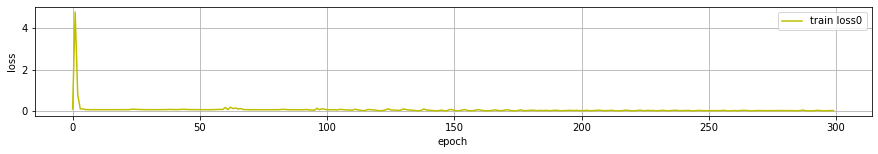

0  result :  0.024159491062164307


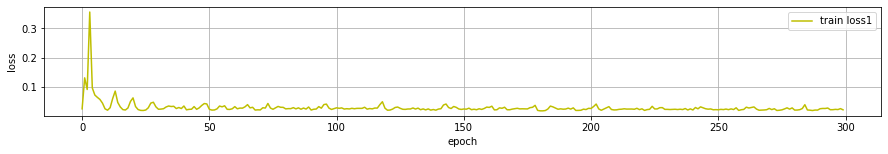

1  result :  0.03213076665997505


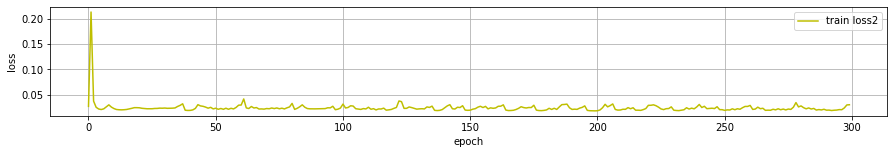

2  result :  0.02181261219084263


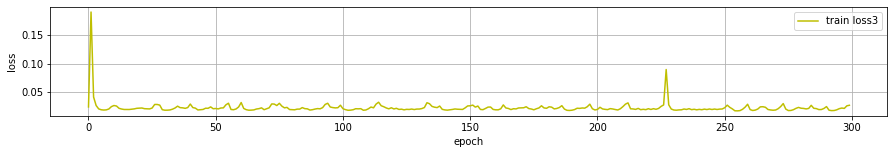

3  result :  0.024692459031939507


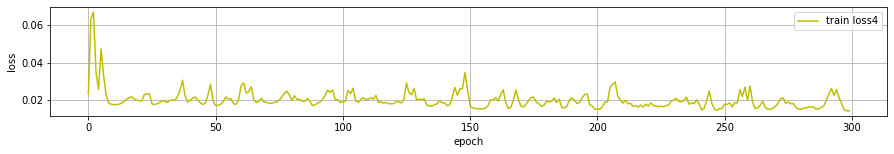

4  result :  0.01746593415737152


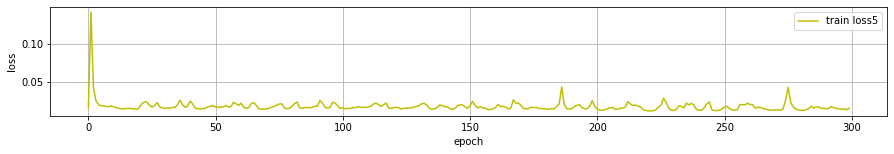

5  result :  0.02027870900928974


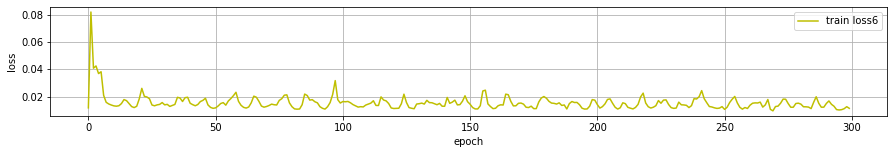

6  result :  0.01899278163909912


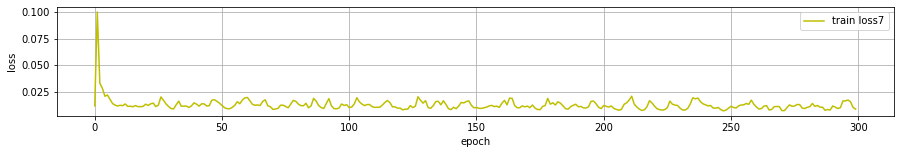

7  result :  0.020038770511746407


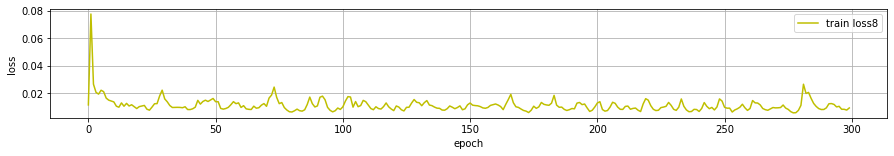

8  result :  0.020577505230903625


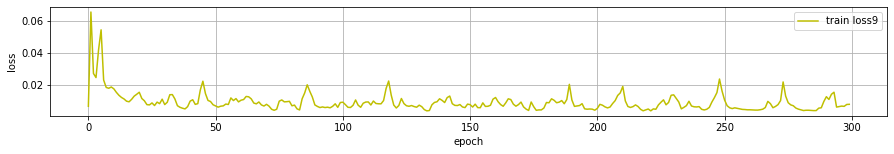

9  result :  0.023201987147331238


In [16]:
# 5. 모델 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt
#plt.rcParams['font.size'] = 15
plt.rcParams["figure.figsize"] = (15,2)

for i in range(MODEL_NUM):
    fig, loss_ax = plt.subplots()
    loss_ax.grid()

    loss_ax.plot(histList[i].history['loss'], 'y', label='train loss'+str(i))
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper right')
    plt.show()
    print(i,' result : ', resultList[i])

# ###########################################################

# Load model해서 예측오차율 보기

In [12]:
modelList = []
print(SAVE_PATH)
for m in range(MODEL_NUM):
    modelList.append(load_model(SAVE_PATH+'model_'+SAVE_NAME+'_'+str(m)+'.h5'))
    
X_train = np.load(SAVE_PATH+"npset_"+SAVE_NAME+"_trainX.npy")
y_train = np.load(SAVE_PATH+"npset_"+SAVE_NAME+"_trainY.npy")
X_test  = np.load(SAVE_PATH+"npset_"+SAVE_NAME+"_testX.npy")
y_test  = np.load(SAVE_PATH+"npset_"+SAVE_NAME+"_testY.npy")

print("X_test : ", X_test.shape)
print("y_test : ", y_test.shape)

C:/elsys/solar/data/20210604_034240_554278/
X_test :  (12, 144, 16)
y_test :  (12, 48, 1)


# train _err rate

In [13]:
predErrRate_list = []
modelList = []
for n in range(MODEL_NUM):
    modelList.append(load_model(SAVE_PATH+'model_'+SAVE_NAME+'_'+str(n)+'.h5'))

for n in range(MODEL_NUM):
    errRate = []
    y = pow_scaler.inverse_transform(y_train[:,:,0])
    plotY = y.reshape(-1,1)

    pred = modelList[n].predict(X_train)[:,:,0]
    pred[pred<0] = 0
    x = pow_scaler.inverse_transform(pred)
    plot_pred = x.reshape(-1,1)

    target_list=[]
    for i in range(0, plotY.shape[0], PRED_STEPS):
        for hr in range(0, PRED_STEPS):
            pred   = plot_pred[i+hr]
            target = plotY[i+hr]
            difference = np.abs(target-pred)
            errRate.append(np.round(difference/CAPACITY*100, 2))
            target_list.append(target)
            
    predErrRate_list.append(errRate)
    print(n," avg;",np.round(sum(predErrRate_list[n])/len(predErrRate_list[n]),2),end='')
    print(" \t max;",np.max(predErrRate_list[n]))
    
# save csv files    
print(np.shape(predErrRate_list))
predErrRate_df = pd.DataFrame(predErrRate_list).transpose()
predErrRate_df.to_csv(SAVE_PATH+"predErrRate_"+SAVE_NAME+"2.csv",mode='w',index=False, encoding='CP949')

#histList_df = pd.DataFrame(histList).transpose()
#histList_df.to_csv(SAVE_PATH+"histList_"+SAVE_NAME+"2.csv",mode='w',index=False, encoding='CP949')

#resultList_df = pd.DataFrame(resultList).transpose()
#resultList_df.to_csv(SAVE_PATH+"resultList_"+SAVE_NAME+"2.csv",mode='w',index=False, encoding='CP949')

print("SAVE_NAME : ", SAVE_NAME)

0  avg; [10.88] 	 max; 104.35
1  avg; [7.52] 	 max; 85.42
2  avg; [5.42] 	 max; 102.63
3  avg; [6.03] 	 max; 88.61
4  avg; [5.38] 	 max; 81.31
5  avg; [3.94] 	 max; 75.6
6  avg; [4.91] 	 max; 63.63
7  avg; [3.7] 	 max; 61.69
8  avg; [3.42] 	 max; 114.03
9  avg; [3.15] 	 max; 33.49
(10, 1584, 1)
SAVE_NAME :  554278_1h_200e_128b


In [14]:
listsize = len(predErrRate_list[0])
count = []
column_names = ["0 < x < 6","(%)","6 < x < 8","(%)","8 < x < 10","(%)", "0 < x < 10","(%)",]
for m in range(MODEL_NUM):
    testList = predErrRate_list[m].copy()
    testList.sort()
    #count = sum(map(lambda x : x>5, listOfElems))
    count.append(int(sum(map(lambda x : x<6, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    count.append(int(sum(map(lambda x : x>6 and x < 8, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    count.append(int(sum(map(lambda x : x>8 and x < 10, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    count.append(np.round(sum(map(lambda x : x < 10, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    
countArr = np.array(count).reshape(10,-1)
countDf = pd.DataFrame(countArr, columns = column_names)
display(countDf)
#count2 = getCount(testList, lambda x : x>5 and x < 20)
#print("{} Model :\t{} \t({}%) \t{} \t({}%) \t{} \t({}%)  \t{} \t({}%)".format(m, int(count1), float(np.round(count1/listsize*100,2)),int(count2), float(np.round(count2/listsize*100,2)),int(count3), float(np.round(count3/listsize*100,2)),int(count4), float(np.round(count4/listsize*100,2))))

<ipython-input-14-e72e2604a92b>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  countArr = np.array(count).reshape(10,-1)


0 < x < 6    (%) 6 < x < 8   (%) 8 < x < 10   (%) 0 < x < 10      (%)
0       815  51.45        76   4.8         66  4.17      [958]  [60.48]
1       965  60.92        93  5.87         71  4.48     [1130]  [71.34]
2      1107  69.89        72  4.55         65   4.1     [1246]  [78.66]
3      1076  67.93       105  6.63         95   6.0     [1278]  [80.68]
4      1091  68.88        70  4.42         72  4.55     [1233]  [77.84]
5      1177  74.31        70  4.42         83  5.24     [1330]  [83.96]
6      1152  72.73        95   6.0         62  3.91     [1313]  [82.89]
7      1224  77.27        79  4.99         65   4.1     [1370]  [86.49]
8      1244  78.54        81  5.11         76   4.8     [1401]  [88.45]
9      1314  82.95        86  5.43         55  3.47     [1455]  [91.86]

TrainY: 66.0 일 ( 1584 시간)


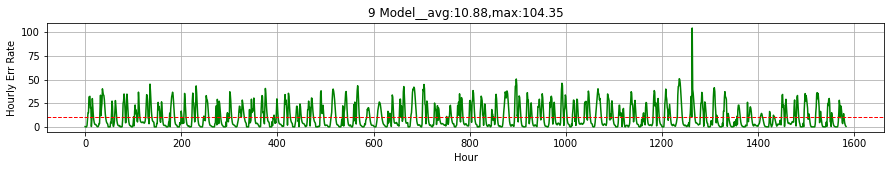

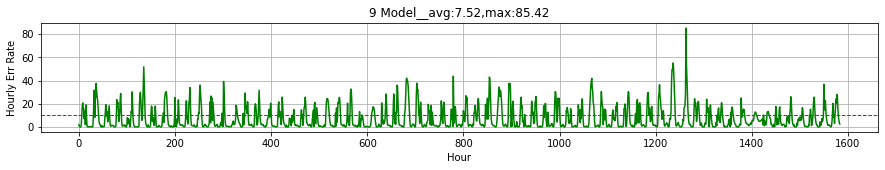

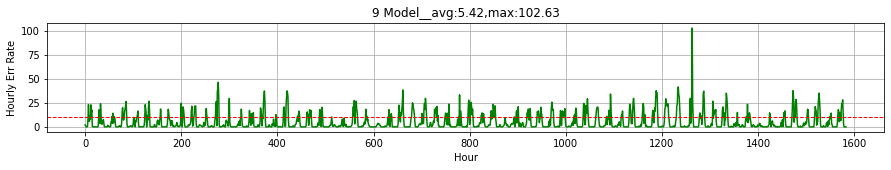

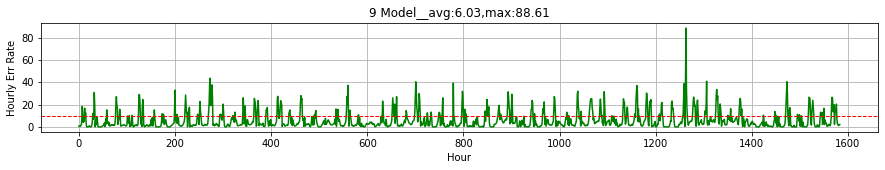

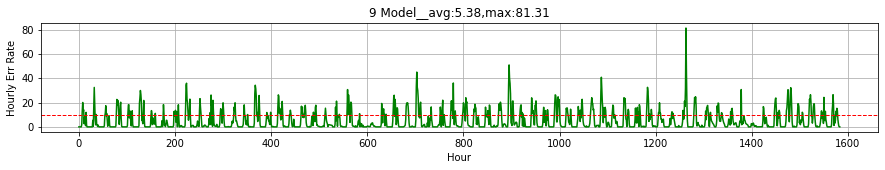

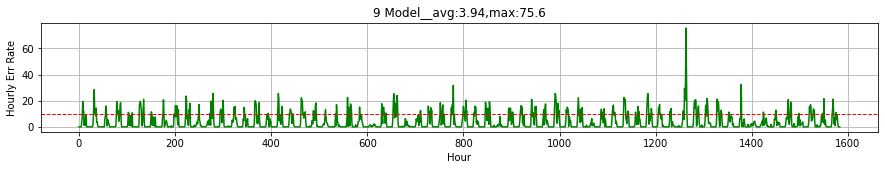

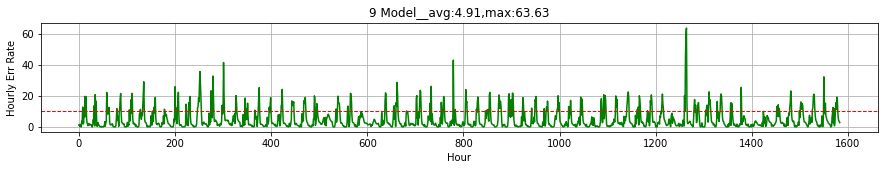

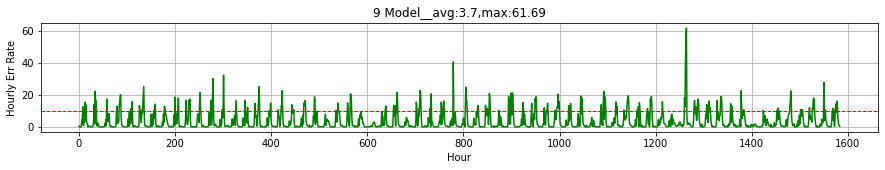

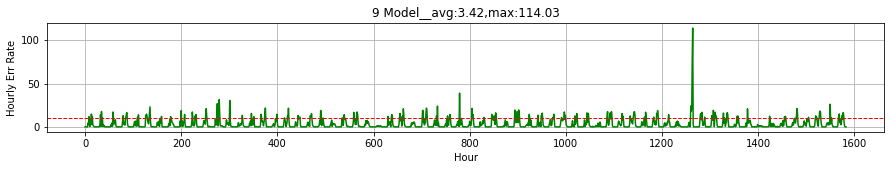

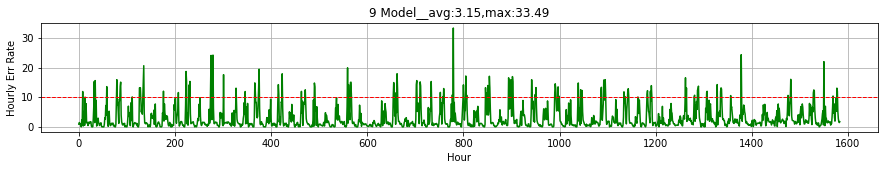

In [15]:
HOUR_STEPS = 24
print("TrainY:",np.rint(np.shape(predErrRate_list[n])[0]/HOUR_STEPS),"일 (", np.shape(predErrRate_list[n])[0],"시간)")

for n in range(MODEL_NUM):
    #print("[ {} MODEL ] mean:{}, max:{}".format(n, np.round(np.mean(predErrRate_list[n]),3), np.max(predErrRate_list[n])))
    mean = np.round(np.mean(predErrRate_list[n]), 2)
    max  = np.round(np.max(predErrRate_list[n]), 2)
    
    #plotAcc = np.array(acc_list).reshape(-1,1)
    plt.rcParams["figure.figsize"] = (15,2)
    #plt.title("Hourly Err Rate(TrainY)")
    plt.title(str(m)+" Model__avg:"+str(mean)+",max:"+str(max))
    plt.xlabel('Hour')
    plt.ylabel('Hourly Err Rate')
    #plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
    #plt.ylim(0,10)
    plt.plot(predErrRate_list[n], 'g-')
    plt.axhline(y=10, color='r',linestyle='--', linewidth=1)
    plt.grid(True)
    plt.show()
    #print(predErrRate_list)

TrainY: 66.0 일 ( 1584 시간)


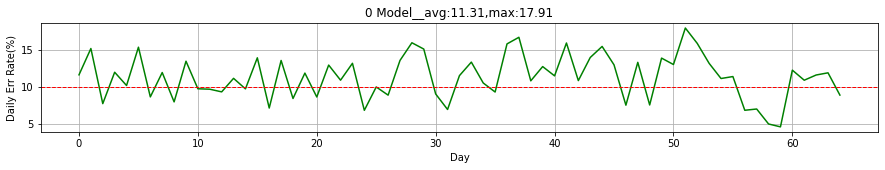

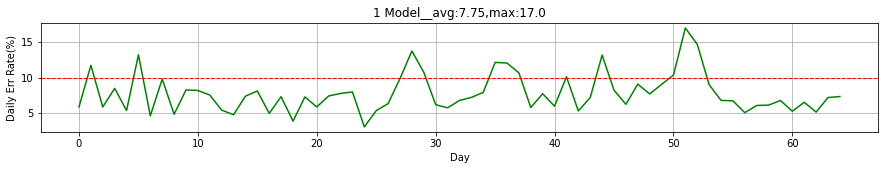

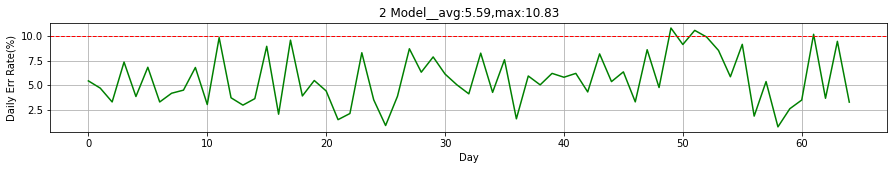

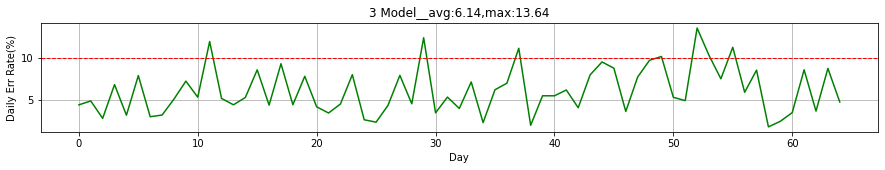

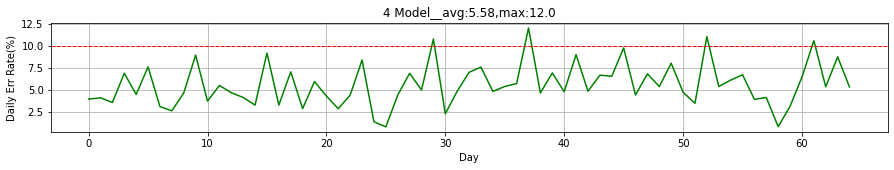

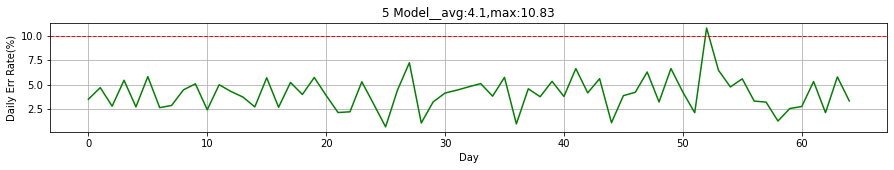

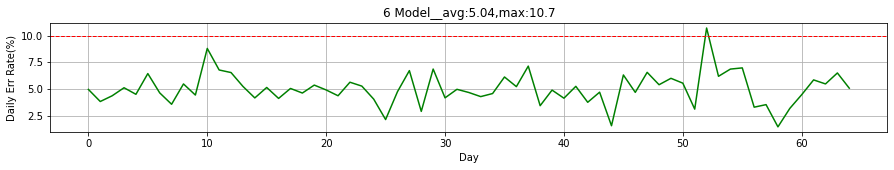

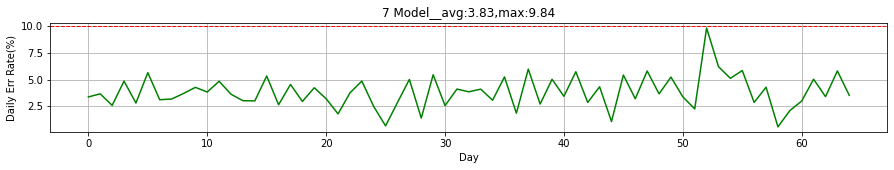

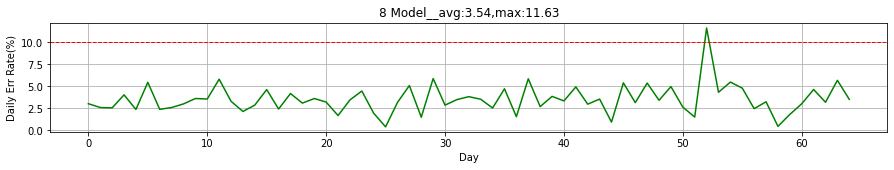

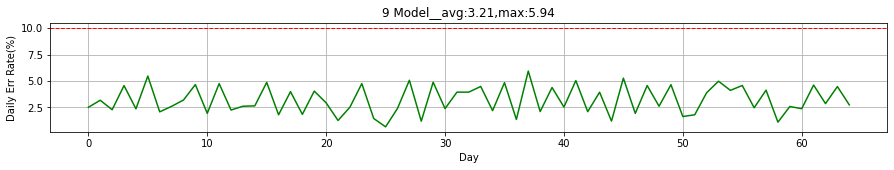

In [16]:
HOUR_STEPS = 24
print("TrainY:",np.rint(np.shape(predErrRate_list[n])[0]/HOUR_STEPS),"일 (", np.shape(predErrRate_list[n])[0],"시간)")

for m in range(MODEL_NUM):
    dailyErrRate = []
    for i in range(0, plotY.shape[0]-HOUR_STEPS, HOUR_STEPS):
        dailyErrRate.append(np.mean(predErrRate_list[m][i:i+HOUR_STEPS-1]))
    mean = np.round(np.mean(dailyErrRate), 2)
    max  = np.round(np.max(dailyErrRate), 2)
    
    #plotAcc = np.array(acc_list).reshape(-1,1)
    plt.rcParams['font.size'] = 10
    plt.rcParams["figure.figsize"] = (15,2)
    plt.title(str(m)+" Model__avg:"+str(mean)+",max:"+str(max))
    plt.xlabel('Day')
    plt.ylabel('Daily Err Rate(%)')
    #plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
    #plt.ylim(0,10)
    plt.plot(dailyErrRate, 'g-')
    plt.axhline(y=10, color='r',linestyle='--', linewidth=1)
    plt.grid(True)
    plt.show()

# TEST _err rate

In [17]:
n_dataset   = y_test.shape[0]
acc_list    = []
acc_model   = []
predictModel = []
predList=[]
predErrRate_list=[]
yList=[]
print(n_dataset)

print("[ model ]")
for m in range(MODEL_NUM):
    errRate=[]
    print("-"*70,"[ model {} ]".format(m))
#for m in range(2):
    plot_target=[]
    plot_predict=[]
    for i in range(n_dataset):
        #print("(dataset {}) : ".format(i), end='')
    #for i in range(5):
    #if(i in [2,3,4,5,6,7,8]): continue;
        y = pow_scaler.inverse_transform(y_test[i:i+1,:,0])
        yList = y.reshape(-1,1)

        pred = modelList[m].predict([X_test[i:i+1]])
        pred[pred<0] = 0
        pred = pred[:,:,0]
        pred = pow_scaler.inverse_transform(pred)
        predSum = np.sum(pred)
        predList = pred.reshape(-1,1)

        target_list=[]
        for i in range(0, yList.shape[0], PRED_STEPS):
            for hr in range(0, PRED_STEPS):
                pred   = predList[i+hr]
                target = yList[i+hr]
                difference = np.abs(target-pred)
                errRate.append(np.round(difference/CAPACITY*100, 2))
                target_list.append(target)

        target      = round(np.sum(y), 2)
        error       = round(np.abs(target-predSum), 2)
        error_rate  = np.min([round(error/target, 2),1])
        acc_rate    = round((1.0-error_rate)*100, 2)
        acc_list.append(acc_rate)
        #print("acc rate: ",np.mean(acc_list[-n_model:]),sep='')
        #predErrRateTest_AllModel.append(predErrRateTest)
        print(np.round(np.mean(acc_list[-MODEL_NUM:]),2), " / ",sep='',end='')
        
    predErrRate_list.append(errRate)
    print(" \tErr Rate avg;",np.round(sum(predErrRate_list[m])/len(predErrRate_list[m]),2),end='')
    print(" \t max;",np.max(predErrRate_list[m]))

print("\npredErrRate_list:{}".format(np.shape(predErrRate_list)))
predErrRate_df = pd.DataFrame(predErrRate_list).transpose()
predErrRate_df.to_csv(SAVE_PATH+"predErrRate_"+SAVE_NAME+"_TEST333.csv",mode='w',index=False, encoding='CP949')
print("----------------------------------------------")
print("mean(acc rate): ",np.mean(acc_list),sep='')
print("----------------------------------------------")
print("[ model ]")
#for m in range(MODEL_NUM):
    #print(predErrRateTest_AllModel[m])
    #acc_model[i] = round(acc_model[i]/(n_dataset),2)
    #print(acc_model[i])

12
[ model ]
---------------------------------------------------------------------- [ model 0 ]
44.0 / 64.0 / 72.67 / 76.25 / 81.0 / 82.83 / 71.0 / 62.12 / 55.22 / 57.0 / 62.5 / 60.8 /  	Err Rate avg; [16.08] 	 max; 62.24
---------------------------------------------------------------------- [ model 1 ]
54.9 / 56.0 / 52.8 / 51.8 / 56.0 / 65.5 / 65.5 / 58.2 / 48.3 / 47.8 / 53.4 / 48.9 /  	Err Rate avg; [14.13] 	 max; 80.64
---------------------------------------------------------------------- [ model 2 ]
46.9 / 47.4 / 52.7 / 52.7 / 60.0 / 69.6 / 69.6 / 63.4 / 54.9 / 57.1 / 62.3 / 60.7 /  	Err Rate avg; [10.] 	 max; 80.09
---------------------------------------------------------------------- [ model 3 ]
53.6 / 54.0 / 54.2 / 54.6 / 58.8 / 67.4 / 67.2 / 59.7 / 49.7 / 48.8 / 54.4 / 49.4 /  	Err Rate avg; [11.29] 	 max; 87.23
---------------------------------------------------------------------- [ model 4 ]
46.2 / 44.4 / 49.8 / 49.6 / 56.3 / 65.5 / 65.5 / 59.3 / 52.5 / 56.6 / 61.5 / 59.9 /  

In [18]:
listsize = len(predErrRate_list[0])
count = []
column_names = ["0 < x < 6","(%)","6 < x < 8","(%)","8 < x < 10","(%)", "0 < x < 10","(%)",]
for m in range(MODEL_NUM):
    testList = predErrRate_list[m].copy()
    testList.sort()
    #count = sum(map(lambda x : x>5, listOfElems))
    count.append(int(sum(map(lambda x : x<6, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    count.append(int(sum(map(lambda x : x>6 and x < 8, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    count.append(int(sum(map(lambda x : x>8 and x < 10, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    count.append(np.round(sum(map(lambda x : x < 10, testList))))
    count.append(np.round(count[-1]/listsize*100,2))
    
countArr = np.array(count).reshape(10,-1)
countDf = pd.DataFrame(countArr, columns = column_names)
display(countDf)

print("0 < x < 10 (%) : AVG {} \t MIN {} \t MAX {}".format(np.mean(countDf.iloc[:,-1]), np.min(countDf.iloc[:,-1]), np.max(countDf.iloc[:,-1])))
#count2 = getCount(testList, lambda x : x>5 and x < 20)
#print("{} Model :\t{} \t({}%) \t{} \t({}%) \t{} \t({}%)  \t{} \t({}%)".format(m, int(count1), float(np.round(count1/listsize*100,2)),int(count2), float(np.round(count2/listsize*100,2)),int(count3), float(np.round(count3/listsize*100,2)),int(count4), float(np.round(count4/listsize*100,2))))

<ipython-input-18-c554454eb602>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  countArr = np.array(count).reshape(10,-1)


0 < x < 6    (%) 6 < x < 8   (%) 8 < x < 10   (%) 0 < x < 10      (%)
0       182   31.6        50  8.68         40  6.94      [272]  [47.22]
1       296  51.39        14  2.43         23  3.99      [333]  [57.81]
2       361  62.67        23  3.99         20  3.47      [404]  [70.14]
3       354  61.46        25  4.34         30  5.21      [409]  [71.01]
4       305  52.95        16  2.78         15   2.6      [336]  [58.33]
5       335  58.16        28  4.86         22  3.82      [386]  [67.01]
6       305  52.95        26  4.51         22  3.82      [353]  [61.28]
7       323  56.08        23  3.99         22  3.82      [368]  [63.89]
8       312  54.17        26  4.51         26  4.51      [365]  [63.37]
9       330  57.29        33  5.73         18  3.12      [381]  [66.15]

0 < x < 10 (%) : AVG [62.621] 	 MIN [47.22] 	 MAX [71.01]


TrainY: 24.0 일 ( 576 시간)


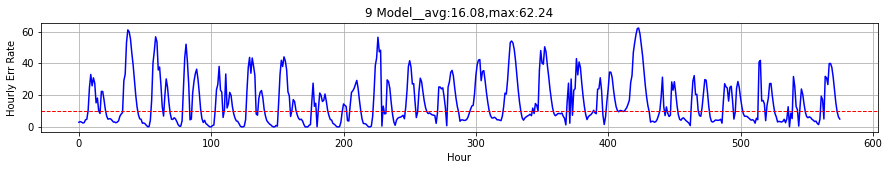

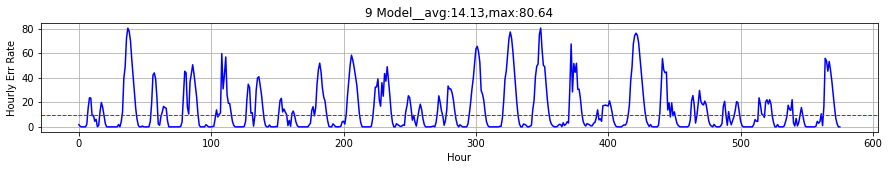

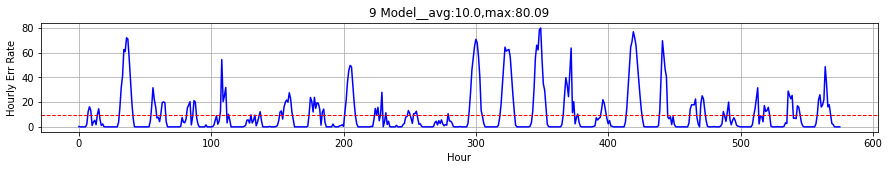

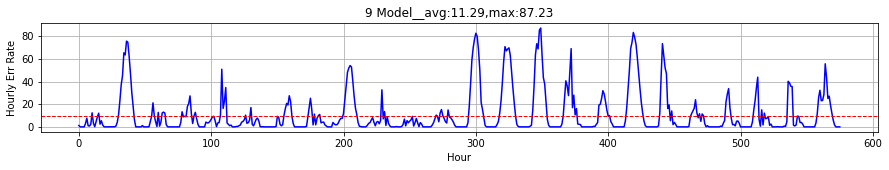

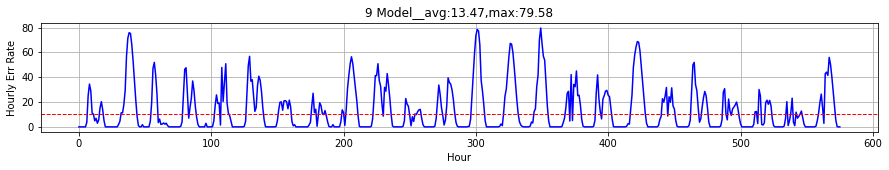

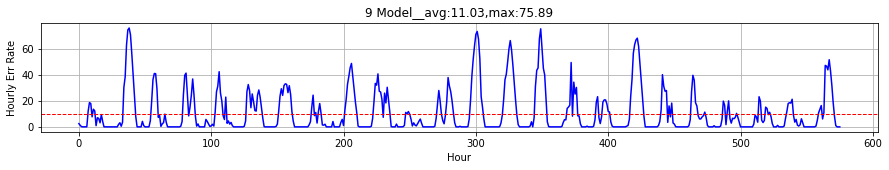

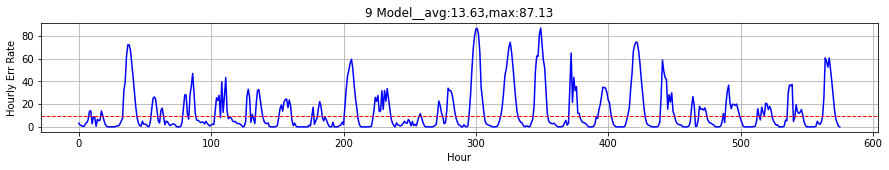

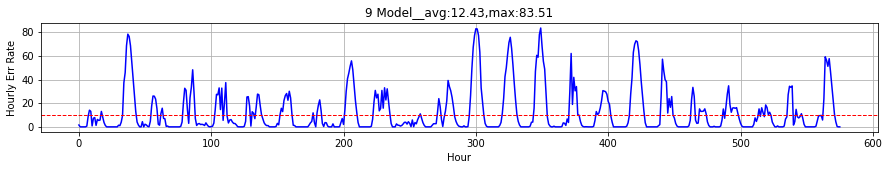

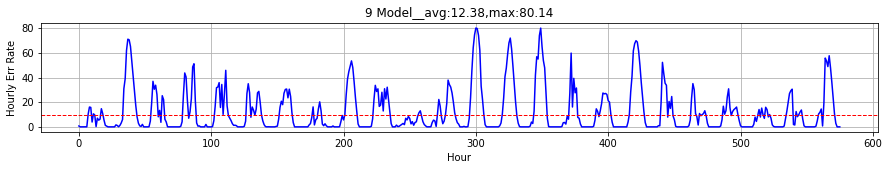

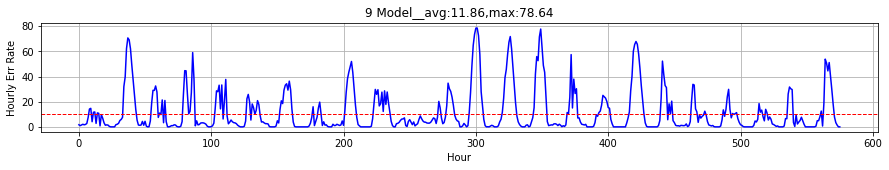

In [19]:
HOUR_STEPS = 24
print("TrainY:",np.rint(np.shape(predErrRate_list[n])[0]/HOUR_STEPS),"일 (", np.shape(predErrRate_list[n])[0],"시간)")

for n in range(MODEL_NUM):
    #print("[ {} MODEL ] mean:{}, max:{}".format(n, np.round(np.mean(predErrRate_list[n]),3), np.max(predErrRate_list[n])))
    mean = np.round(np.mean(predErrRate_list[n]), 2)
    max  = np.round(np.max(predErrRate_list[n]), 2)
    
    #plotAcc = np.array(acc_list).reshape(-1,1)
    plt.rcParams["figure.figsize"] = (15,2)
    #plt.title("Hourly Err Rate(TrainY)")
    plt.title(str(m)+" Model__avg:"+str(mean)+",max:"+str(max))
    plt.xlabel('Hour')
    plt.ylabel('Hourly Err Rate')
    #plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
    #plt.ylim(0,10)
    plt.plot(predErrRate_list[n], 'b-')
    plt.axhline(y=10, color='r',linestyle='--', linewidth=1)
    plt.grid(True)
    plt.show()
    #print(predErrRate_list)

TrainY: 24.0 일 ( 576 시간)


c:\users\vislab_phy\anaconda3\envs\py_38_shap\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\vislab_phy\anaconda3\envs\py_38_shap\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


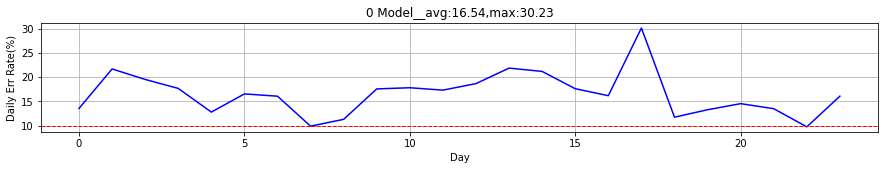

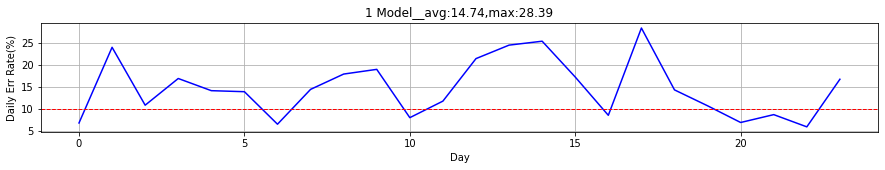

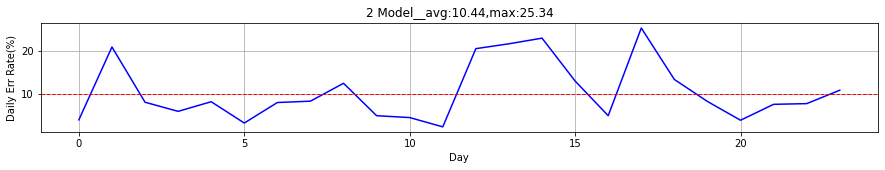

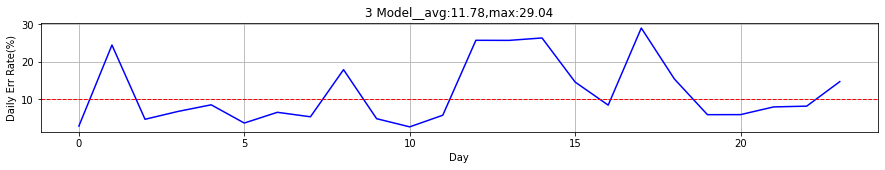

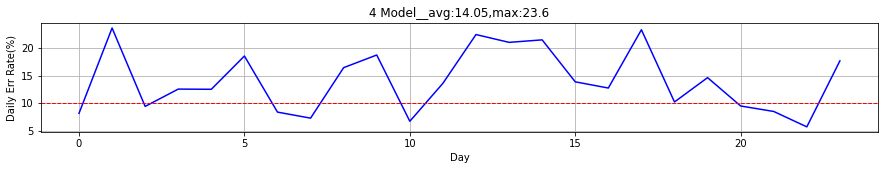

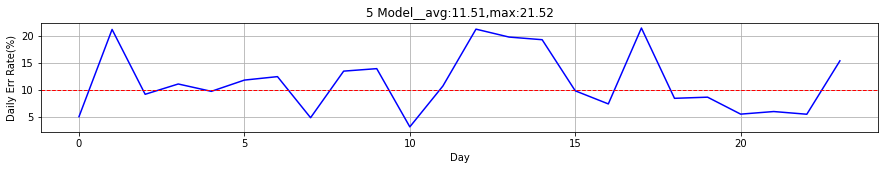

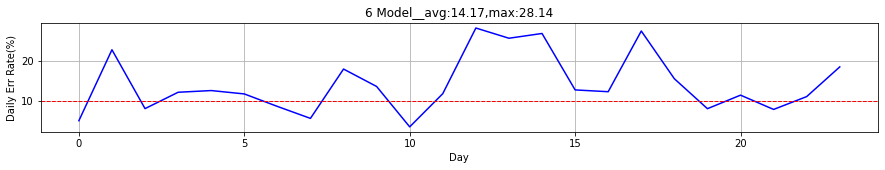

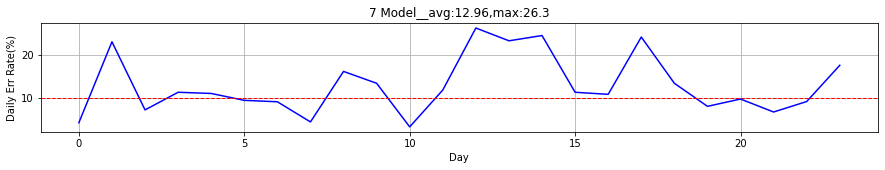

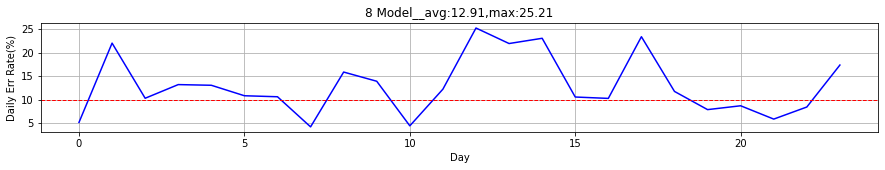

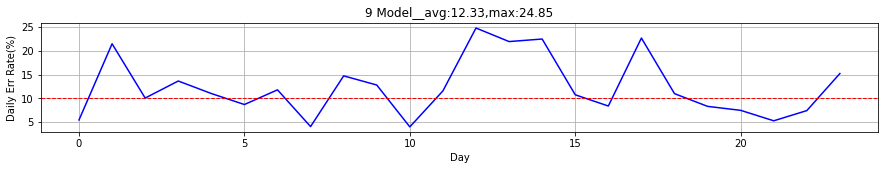

In [20]:
HOUR_STEPS = 24
print("TrainY:",np.rint(np.shape(predErrRate_list[n])[0]/HOUR_STEPS),"일 (", np.shape(predErrRate_list[n])[0],"시간)")

for m in range(MODEL_NUM):
    dailyErrRate = []
    for i in range(0, plotY.shape[0]-HOUR_STEPS, HOUR_STEPS):
        dailyErrRate.append(np.mean(predErrRate_list[m][i:i+HOUR_STEPS-1]))
        
    dailyErrRate = [x for x in dailyErrRate if np.isnan(x) == False]
    mean = np.round(np.mean(dailyErrRate), 2)
    max  = np.round(np.max(dailyErrRate), 2)
    
    #plotAcc = np.array(acc_list).reshape(-1,1)
    plt.rcParams['font.size'] = 10
    plt.rcParams["figure.figsize"] = (15,2)
    plt.title(str(m)+" Model__avg:"+str(mean)+",max:"+str(max))
    plt.xlabel('Day')
    plt.ylabel('Daily Err Rate(%)')
    #plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
    #plt.ylim(0,10)
    plt.plot(dailyErrRate, 'b-')
    plt.axhline(y=10, color='r',linestyle='--', linewidth=1)
    plt.grid(True)
    plt.show()

In [21]:
plt.rcParams['font.size'] = 20
y = pow_scaler.inverse_transform(y_test[:,:,0])
plotY = y.reshape(-1,1)
print("step: ",plotY.shape[0])
print(int(plotY.shape[0]/HOUR_STEPS))

step:  576
24


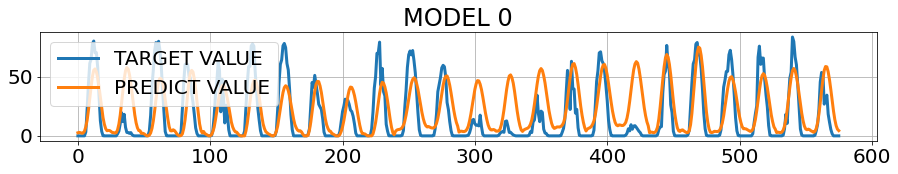

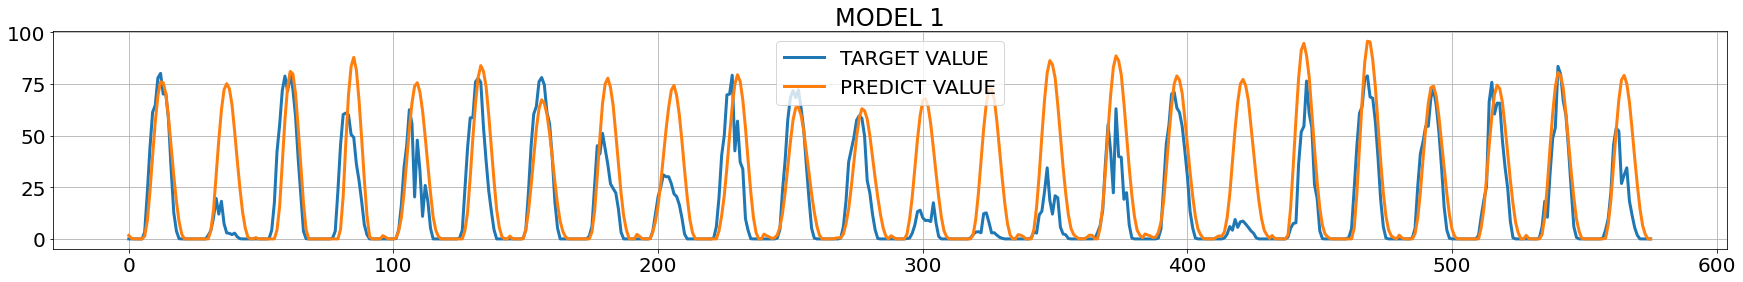

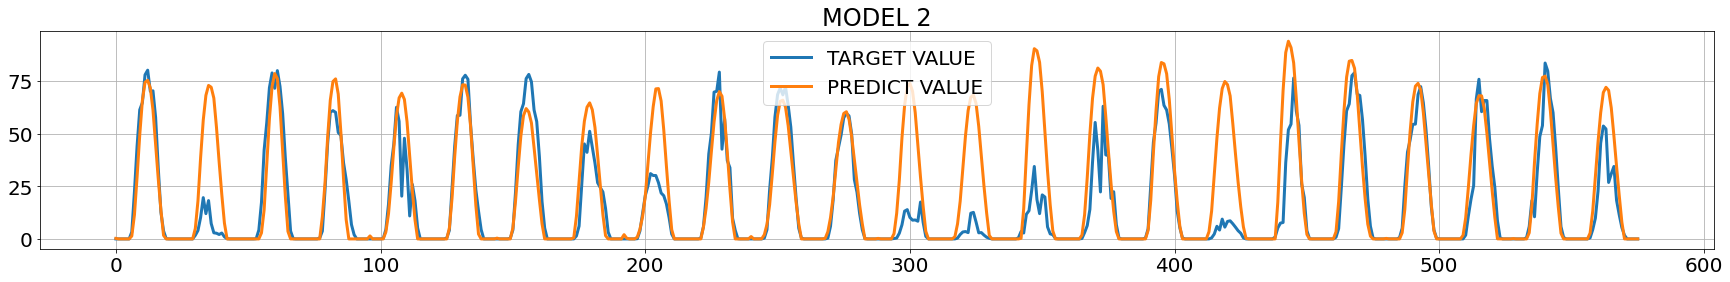

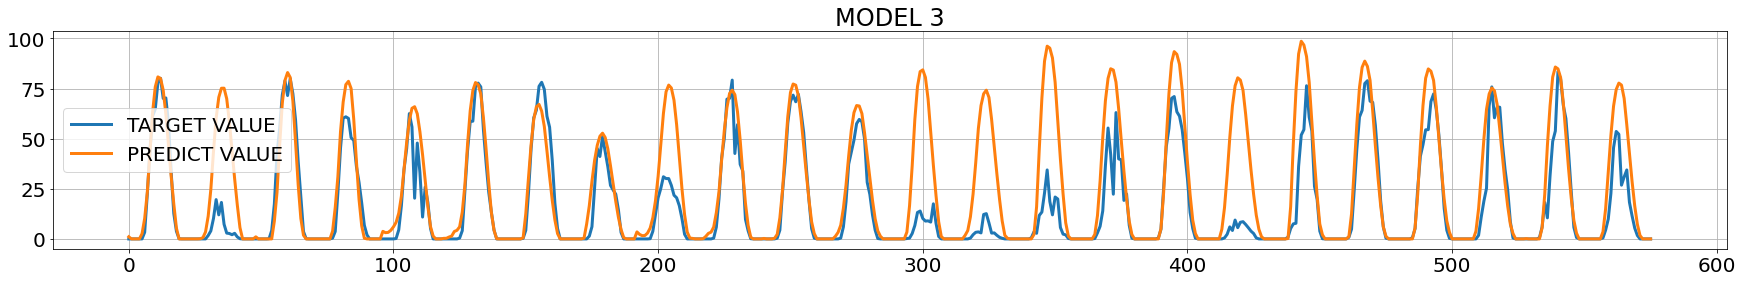

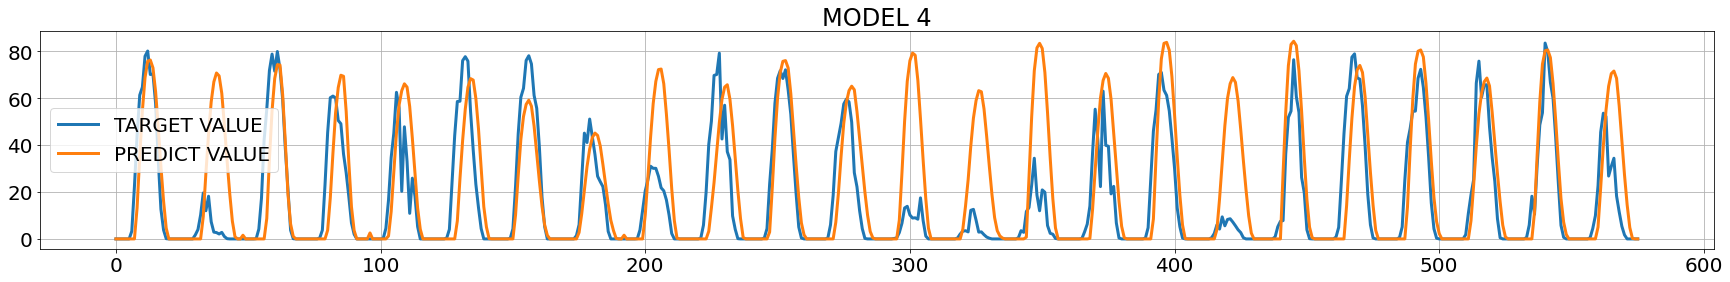

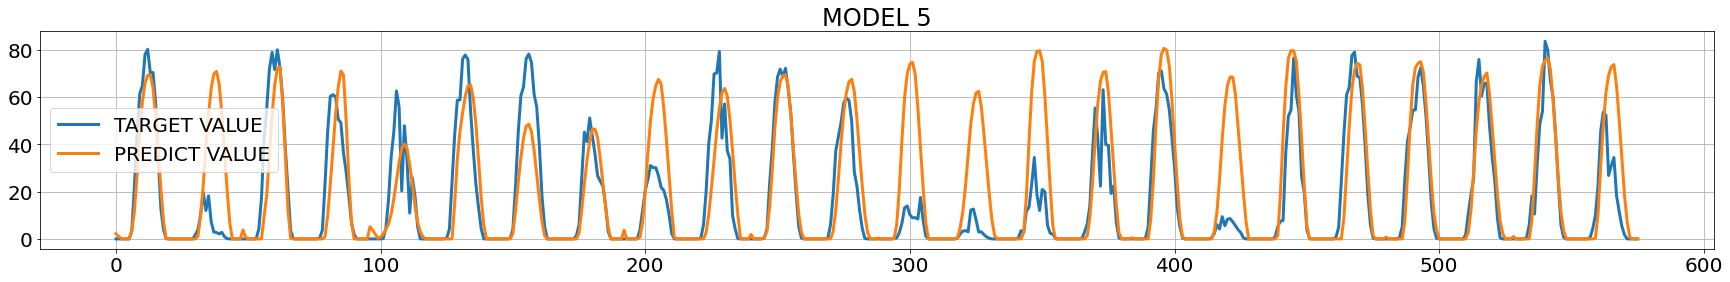

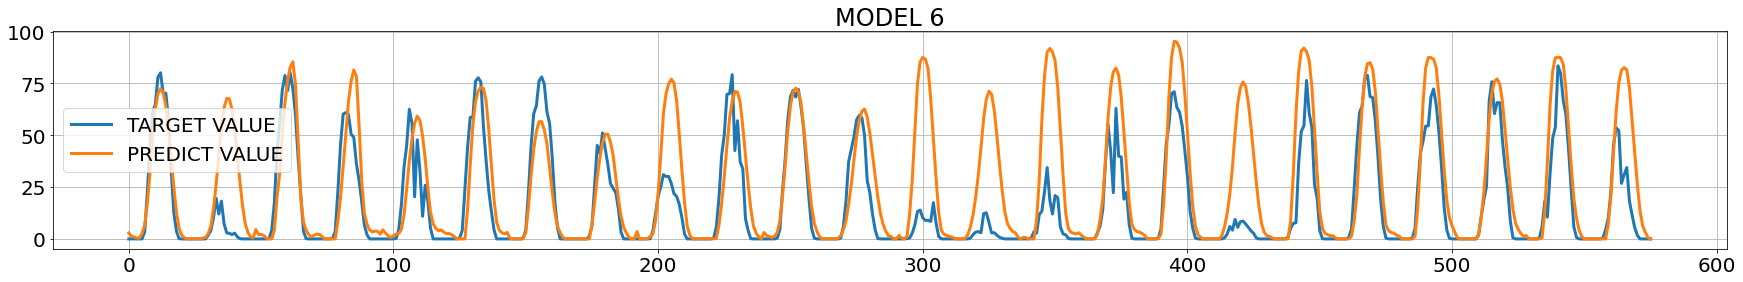

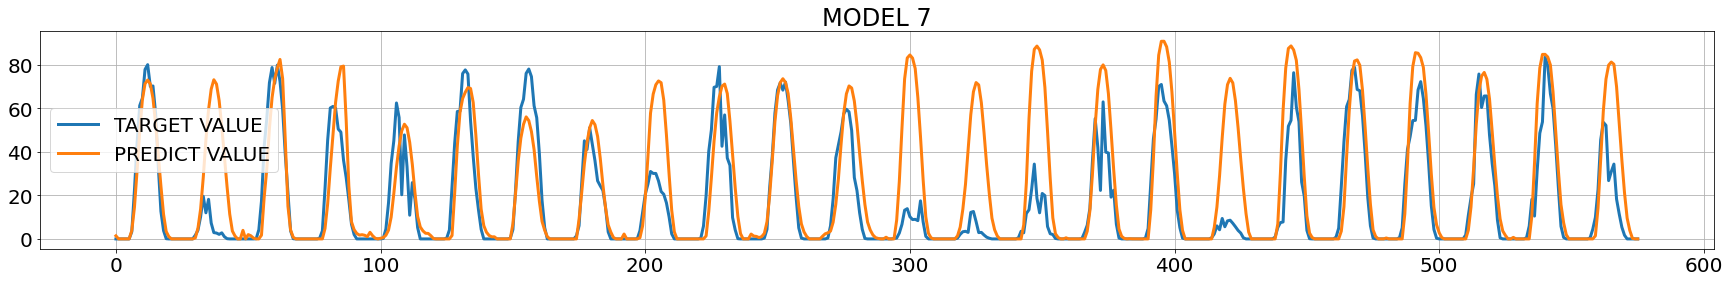

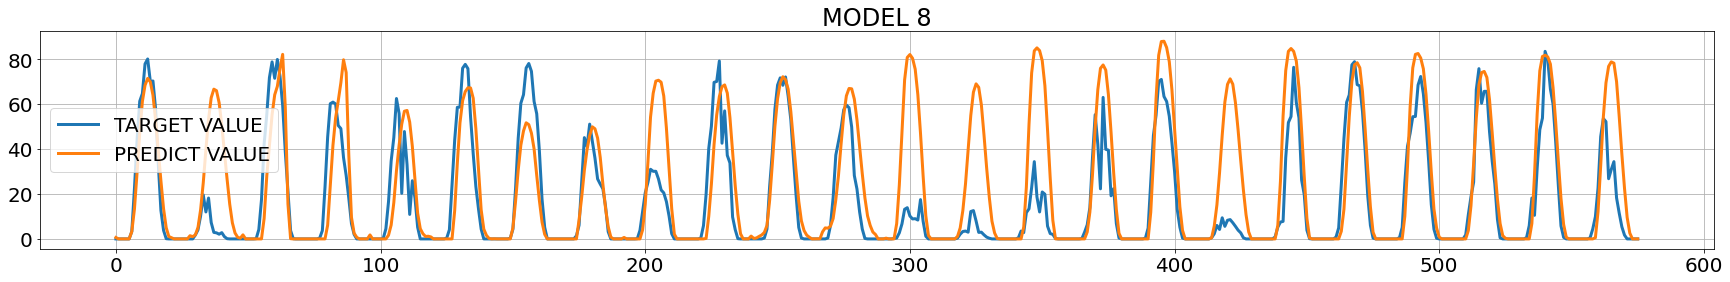

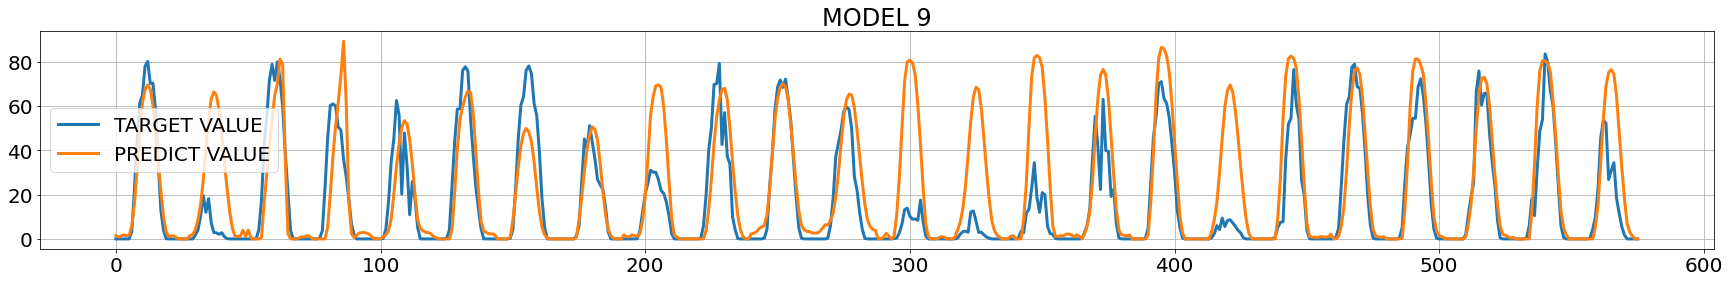

In [22]:
y = pow_scaler.inverse_transform(y_test[:,:,0])
plotY = y.reshape(-1,1)
step = int(plotY.shape[0])

for m in range(MODEL_NUM):
    pred = modelList[m].predict(X_test)[:,:,0]
    pred[pred<0] = 0

    x = pow_scaler.inverse_transform(pred)
    plotY_pred = x.reshape(-1,1)

    acc_list = []
    target_list=[]

    for i in range(0, plotY.shape[0]-step+1, step):
        plt.title("MODEL "+str(m))
        plt.rcParams["figure.figsize"] = (30,4)
        plt.plot(plotY[i:i+step], label="TARGET VALUE",linewidth=3)#,linewidth=4, alpha=0.7)
        plt.plot(plotY_pred[i:i+step],label="PREDICT VALUE",linewidth=3)#,linewidth=2, alpha=1)
        plt.grid()
        plt.legend()
        plt.show()

In [24]:
plotY = trainY.reshape(-1,1)
plotY_pred = model.predict(trainX).reshape(-1,1)
plotY_pred[plotY_pred<0] = 0

step = hoursteps*7 #timesteps#
print(plotY.shape[0],'-',step)
for i in range(0, plotY.shape[0]-step, step):
    plt.rcParams["figure.figsize"] = (25,4)
    plt.plot(plotY[i:i+step], label="target",linewidth=4, alpha=1)
    plt.plot(plotY_pred[i:i+step], label="output",linewidth=4, alpha=1)
    #plt.plot(plotY[i:i+step], 'r-', label="target",linewidth=2, alpha=1)
    #plt.plot(plotY_pred[i:i+step], 'y-', label="output",linewidth=2, alpha=1)
    plt.grid()
    plt.legend()
    plt.show()


NameError: name 'trainY' is not defined

# 여기 위에까지~

test data :  40.0 일 ( 1920 시간)
mean(err rate): 9.149
 max(err rate): 78.08


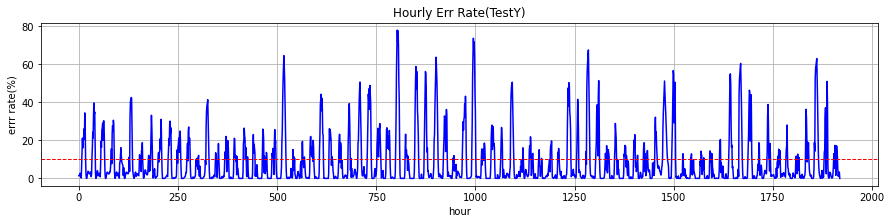

test data :  40.0 일 ( 1920 시간)
mean(err rate): 9.149
 max(err rate): 78.08


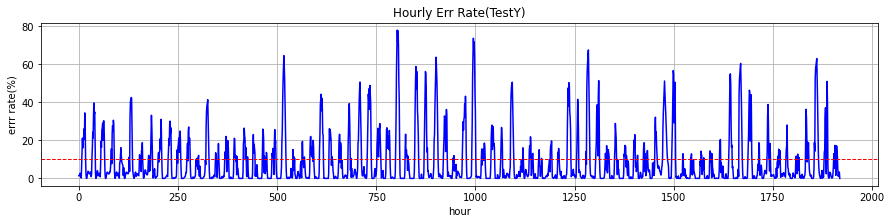

test data :  40.0 일 ( 1920 시간)
mean(err rate): 9.149
 max(err rate): 78.08


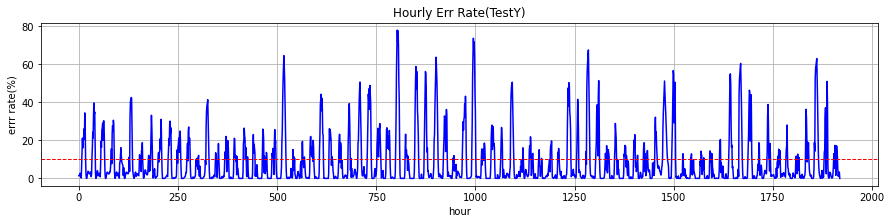

test data :  40.0 일 ( 1920 시간)
mean(err rate): 9.149
 max(err rate): 78.08


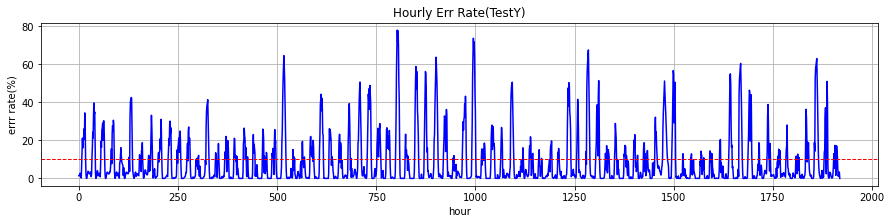

test data :  40.0 일 ( 1920 시간)
mean(err rate): 9.149
 max(err rate): 78.08


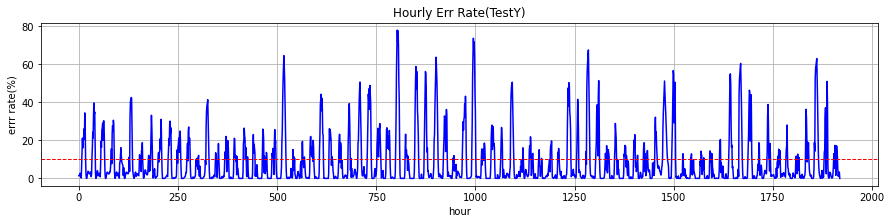

test data :  40.0 일 ( 1920 시간)
mean(err rate): 9.149
 max(err rate): 78.08


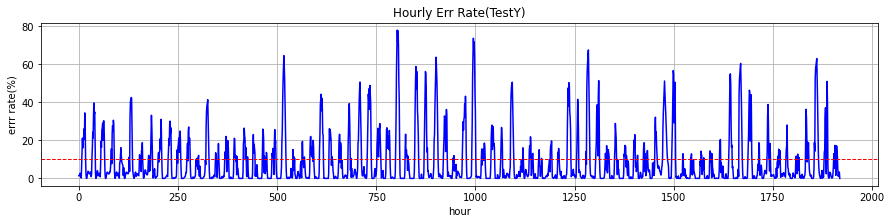

test data :  40.0 일 ( 1920 시간)
mean(err rate): 9.149
 max(err rate): 78.08


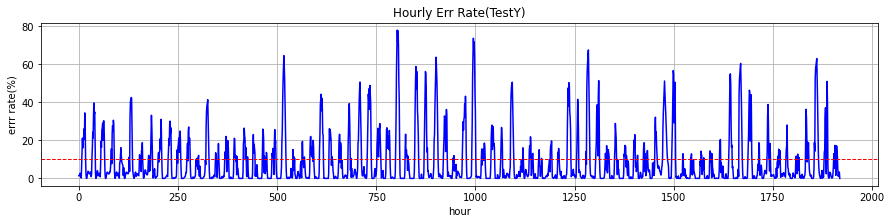

test data :  40.0 일 ( 1920 시간)
mean(err rate): 9.149
 max(err rate): 78.08


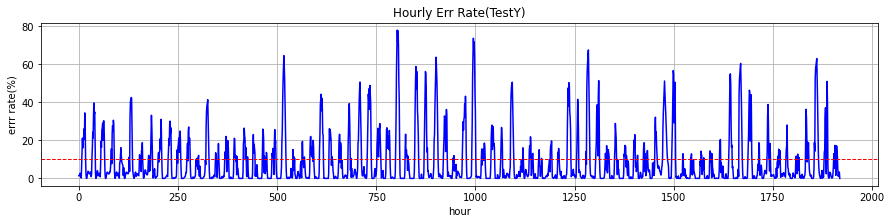

test data :  40.0 일 ( 1920 시간)
mean(err rate): 9.149
 max(err rate): 78.08


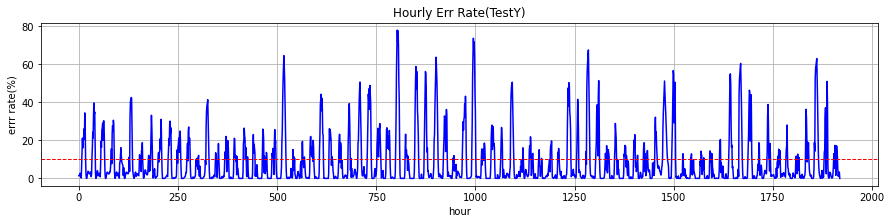

test data :  40.0 일 ( 1920 시간)
mean(err rate): 9.149
 max(err rate): 78.08


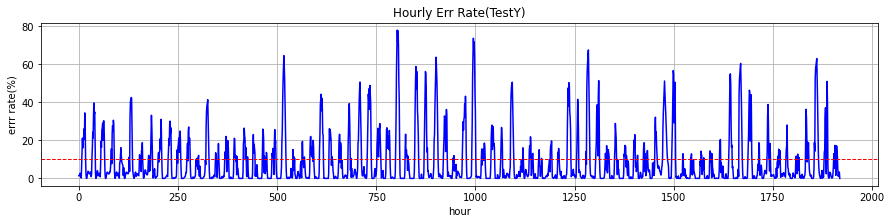

In [37]:
for n in range(MODEL_NUM):
    print("test data : ", np.rint(np.shape(predErrRate_All[n])[0]/PRED_STEPS),"일 (", np.shape(predErrRate_All[n])[0],"시간)",)
    print("mean(err rate): ",np.round(np.mean(predErrRate_All[n]),3),sep='')
    print(" max(err rate): ",np.max(predErrRate_All[n]),sep='')

    #plotAcc = np.array(acc_list).reshape(-1,1)
    plt.rcParams["figure.figsize"] = (15,3)
    plt.title("Hourly Err Rate(TestY)")
    plt.xlabel('hour')
    plt.ylabel('errr rate(%)')
    #plt.yticks([0,1,2,3,4,5,6,7,8,9,10])
    #plt.ylim(0,10)
    plt.plot(predErrRate_All[n], 'b-')
    plt.axhline(y=10, color='r',linestyle='--', linewidth=1)
    plt.grid(True)
    plt.show()
    #print(predErrRate_list)

In [13]:
show_shapes()
print(np.shape(trainY), type(trainY))

Expected: (num_samples, timesteps, channels)
trainX:float64	 (28, 144, 17) 	/ float64	 (28, 48, 1)
valX:  float64	 (8, 144, 17) 	/ float64	 (8, 48, 1)
testX: float64	 (4, 144, 17) 	/ float64	 (4, 48, 1)
(28, 48, 1) <class 'numpy.ndarray'>


In [ ]:
#modelList = []
#modelList.append(load_model('model/model_'+save_name+'_'+str(i)+'.h5'))

for i in range(MODEL_NUM):
    plotY = trainY.reshape(-1,1)
    plotY_pred = modelList[i].predict(trainX).reshape(-1,1)
    plotY_pred[plotY_pred<0] = 0

    step = hoursteps*7
    print(plotY.shape[0],'-',step)
    for i in range(0, plotY.shape[0]-step, step):
        plt.rcParams["figure.figsize"] = (25,4)
        plt.plot(plotY[i:i+step], label="target",linewidth=4, alpha=1)
        plt.plot(plotY_pred[i:i+step], label="output",linewidth=4, alpha=1)
        #plt.plot(plotY[i:i+step], 'r-', label="target",linewidth=2, alpha=1)
        #plt.plot(plotY_pred[i:i+step], 'y-', label="output",linewidth=2, alpha=1)
        plt.grid()
        plt.legend()
        plt.show()


In [46]:
modelList = []
modelList.append(load_model('model/model_'+save_name+'_'+str(i)+'.h5'))

for i in range(MODEL_NUM):
    plotY = trainY.reshape(-1,1)
    plotY_pred = modelList[i].predict(trainX).reshape(-1,1)
    plotY_pred[plotY_pred<0] = 0

    step = hoursteps*7
    print(plotY.shape[0],'-',step)
    for i in range(0, plotY.shape[0]-step, step):
        plt.rcParams["figure.figsize"] = (25,4)
        plt.plot(plotY[i:i+step], label="target",linewidth=4, alpha=1)
        plt.plot(plotY_pred[i:i+step], label="output",linewidth=4, alpha=1)
        #plt.plot(plotY[i:i+step], 'r-', label="target",linewidth=2, alpha=1)
        #plt.plot(plotY_pred[i:i+step], 'y-', label="output",linewidth=2, alpha=1)
        plt.grid()
        plt.legend()
        plt.show()


NameError: name 'load_model' is not defined

step:  1008
MODEL  0


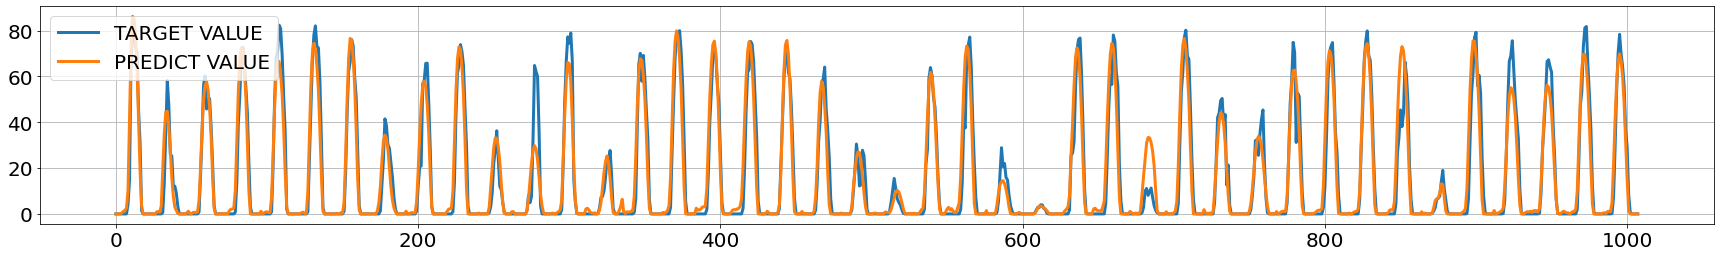

MODEL  1


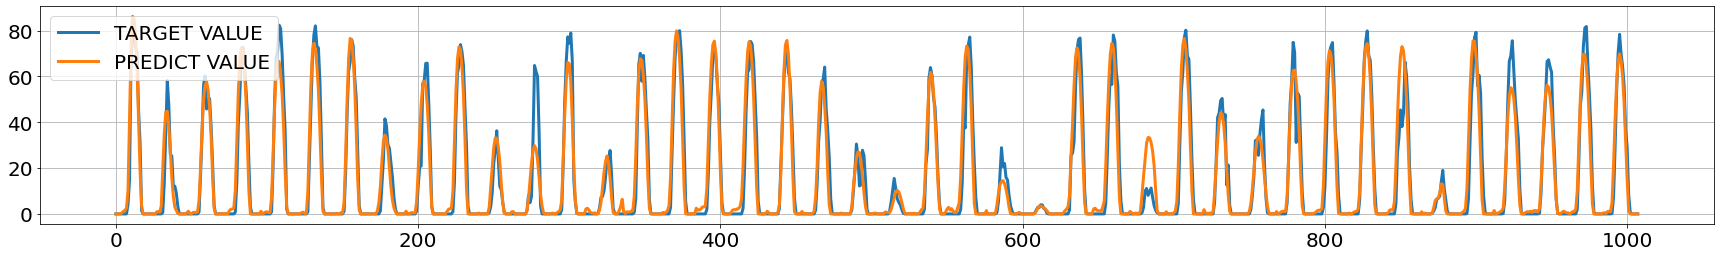

MODEL  2


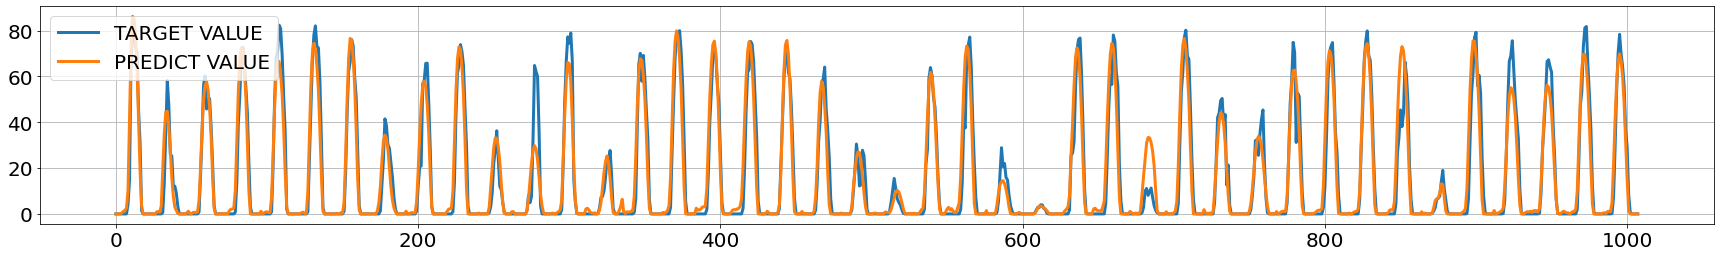

MODEL  3


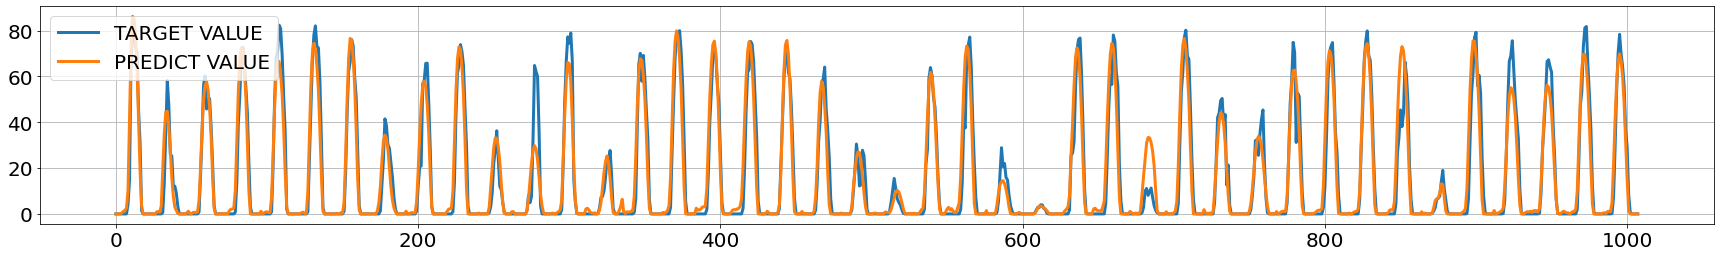

MODEL  4


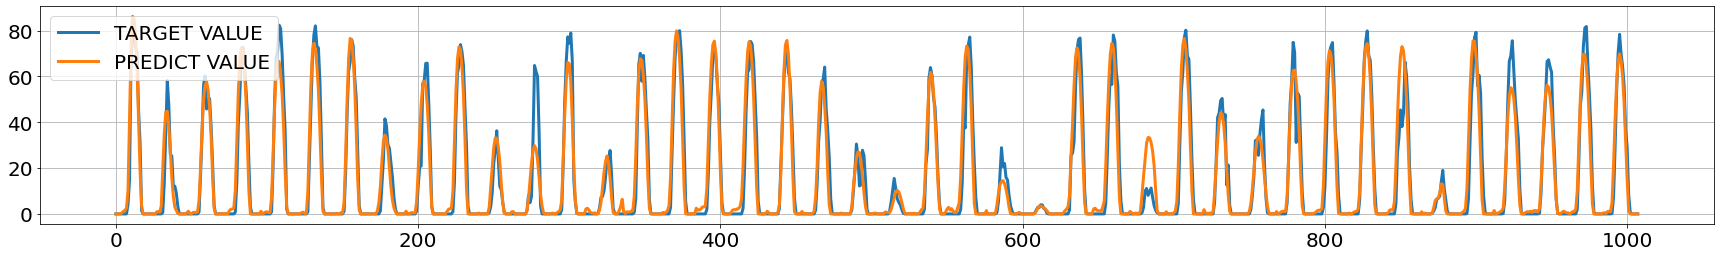

MODEL  5


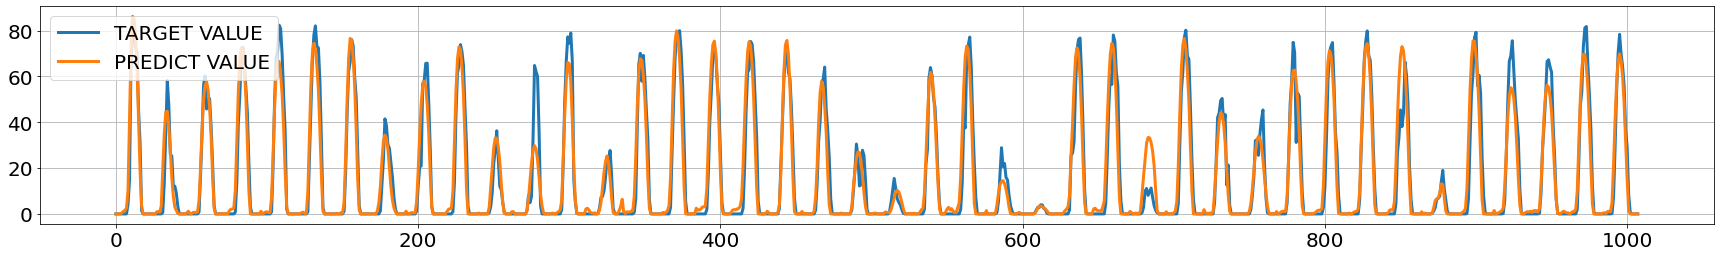

MODEL  6


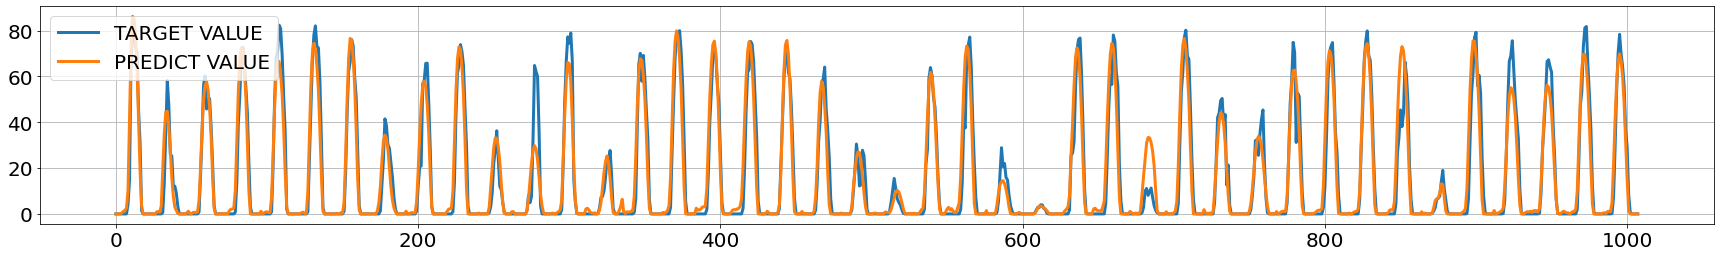

MODEL  7


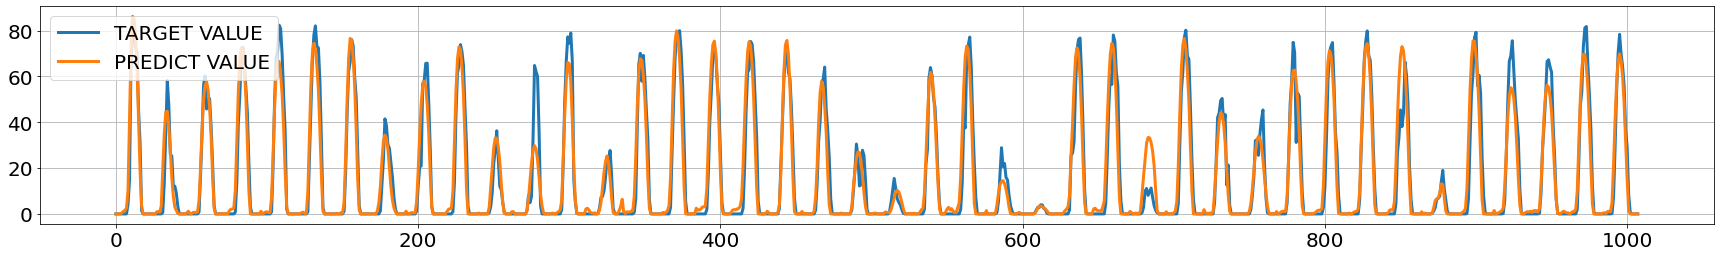

MODEL  8


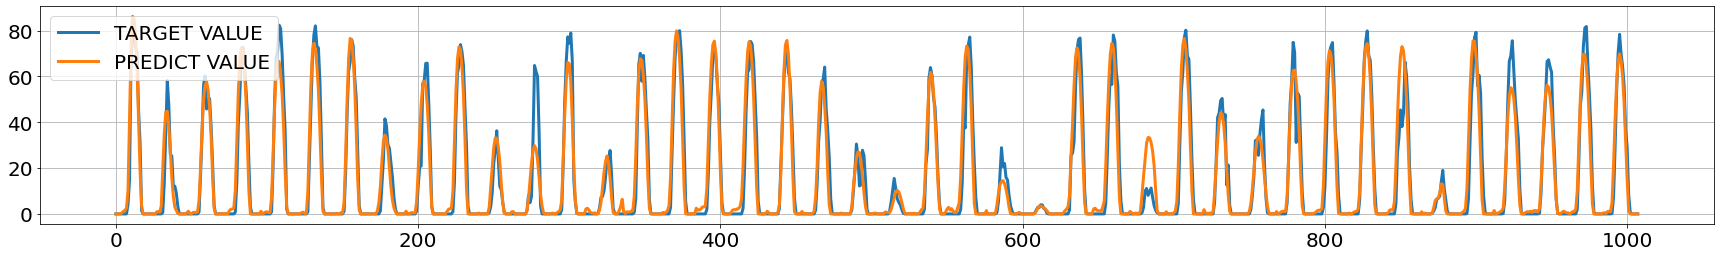

MODEL  9


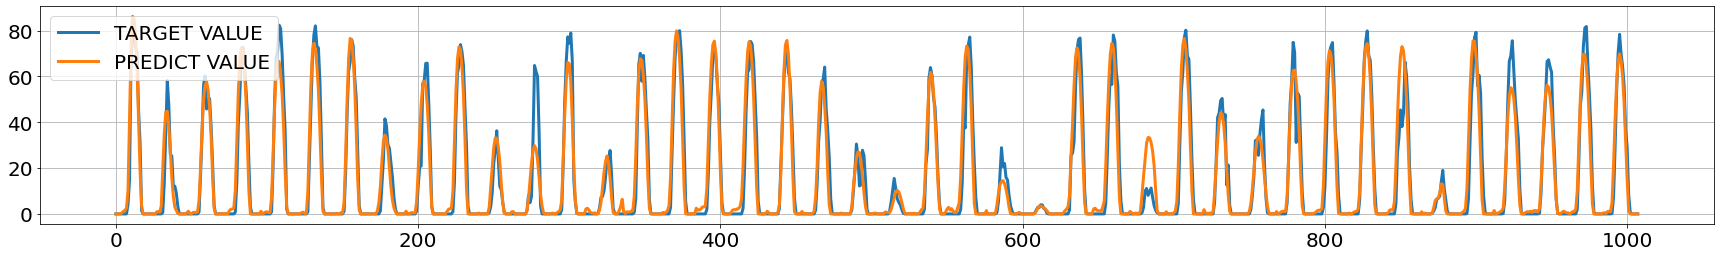

In [37]:
plt.rcParams['font.size'] = 20
y = pow_scaler.inverse_transform(trainY[:,:,0])
plotY = y.reshape(-1,1)
print("step: ",hoursteps*21)


for i in range(MODEL_NUM):
    print("MODEL ",i)
    pred = modelList[i].predict(trainX)[:,:,0]
    pred[pred<0] = 0

    x = pow_scaler.inverse_transform(pred)
    plotY_pred = x.reshape(-1,1)

    acc_list = []
    target_list=[]

    step = hoursteps*21
    for i in range(0, plotY.shape[0]-step, step):
    #for i in range(0, plotY.shape[0]-hoursteps, hoursteps):
    #for i in range(0, 240-step, step):
        plt.rcParams["figure.figsize"] = (30,4)
        plt.plot(plotY[i:i+step], label="TARGET VALUE",linewidth=3)#,linewidth=4, alpha=0.7)
        plt.plot(plotY_pred[i:i+step],label="PREDICT VALUE",linewidth=3)#,linewidth=2, alpha=1)
        #plt.plot(plotY[i:i+step], 'r-', label="target",linewidth=2, alpha=1)
        #plt.plot(plotY_pred[i:i+step], 'y-', label="output",linewidth=2, alpha=1)
        plt.grid()
        plt.legend()
        plt.show()

    #plt.tight_layout()
    #plt.savefig(save_path+'/predict.jpg')
    #plt.show()
    #print(plotY_pred)

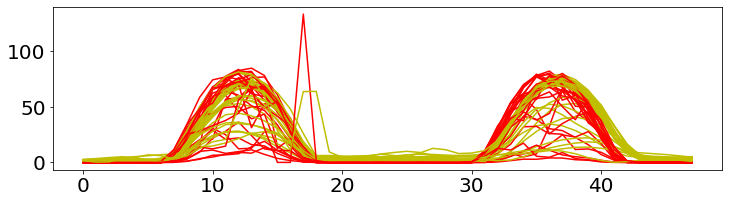

In [20]:
y = pow_scaler.inverse_transform(trainY[:,:,0])
plotY = y.reshape(-1,1)

pred = model.predict(trainX)[:,:,0]
pred[pred<0] = 0

x = pow_scaler.inverse_transform(pred)
plot_pred = x.reshape(-1,1)

acc_list = []
target_list=[]
predErrRate_list = []

for i in range(0, plotY.shape[0]-hoursteps, hoursteps):
    plt.rcParams["figure.figsize"] = (12,3)
    plt.plot(plotY[i:i+hoursteps], 'r-', label="target")
    plt.plot(plot_pred[i:i+hoursteps], 'y-', label="output")
    #plt.legend()
    #plt.show()
    
    pred = np.sum(plot_pred[i:i+hoursteps])
    target      = round(np.sum(plotY[i:i+hoursteps]), 2)
    
    error       = round(np.abs(target-pred), 2)
    error_rate  = round(error/target, 2)
    acc_rate    = np.max([round((1.0-error_rate)*100, 2),0])
    
    
    predErrRate = round(np.abs((target-pred)/920.2*100), 2)
    predErrRate_list.append(predErrRate)
    
    target_list.append(target)
    acc_list.append(acc_rate)
    #print("   pred: ",pred," | target: ",target," | error: ",error," | err rate: ",error_rate," | acc: ",acc_rate,sep="")

mean(acc rate): 76.70370370370371


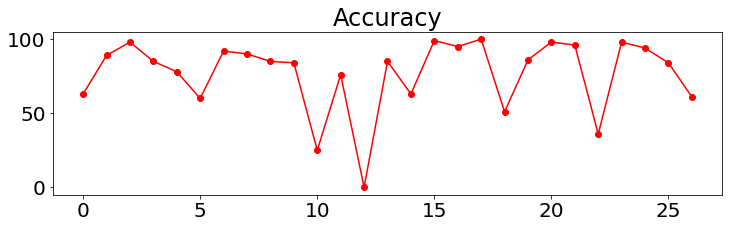

[63.0, 89.0, 98.0, 85.0, 78.0, 60.0, 92.0, 90.0, 85.0, 84.0, 25.0, 76.0, 0.0, 85.0, 63.0, 99.0, 95.0, 100.0, 51.0, 86.0, 98.0, 96.0, 36.0, 98.0, 94.0, 84.0, 61.0]


In [21]:
print("mean(acc rate): ",np.mean(acc_list),sep='')
    
#plotAcc = np.array(acc_list).reshape(-1,1)
plt.plot(acc_list, 'ro-')
plt.title("Accuracy")
plt.rcParams["figure.figsize"] = (12,3)
plt.show()
print(acc_list)

# Test dataset